# Bike Rental Demand Forecasting

This notebook demonstrates a complete machine learning workflow for predicting bike rental demand using various regression models. The analysis includes data preprocessing, exploratory data analysis (EDA), model training with cross-validation, and comprehensive evaluation.

## Project Overview

**Goal**: Predict hourly bike rental demand based on temporal and weather features

**Dataset**: 1-year bike rental data (2012) with hourly granularity

**Models Evaluated**:
- Decision Tree Regressor
- Random Forest Regressor  
- Support Vector Machine
- Gradient Boosting
- Neural Network

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from rich import print as rprint
from rich.table import Table

In [3]:
RANDOM_SEED = 42

## Configuration

Setting a consistent random seed ensures reproducibility across all experiments. This allows others to replicate our results exactly.

## 1. Data Preprocessing

Data preprocessing is critical for model performance. We'll:
1. Load and inspect the data
2. Remove unnecessary columns
3. Handle missing values and duplicates
4. Validate data against business rules
5. Encode categorical variables
6. Detect and remove outliers

In [4]:
df = pd.read_csv('z2_data_1y.csv', delimiter=';')
print(f"Dataset consists of {df.shape[0]} rows and {df.shape[1]} columns.")

print("First 5 rows:")
print(df.head())

df.info()

Dataset consists of 8741 rows and 12 columns.
First 5 rows:
   instant        date  month  hour  holiday  weekday  workingday weather  \
0        1  2012-12-20     12     6      0.0        4        True  cloudy   
1        2  2012-11-14     11     9      0.0        3        True   clear   
2        3  2012-08-23      8     3      0.0        4        True   clear   
3        4  2012-05-24      5     8      0.0        4        True   clear   
4        5  2012-10-06     10    13      0.0        6       False  cloudy   

   temperature  humidity  windspeed  count  
0         6.10      65.0        0.0    118  
1         6.10      52.0       26.0    332  
2        21.14      83.0        6.0      9  
3        21.14      73.0        9.0    692  
4        22.08      57.0       35.0    710  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8741 entries, 0 to 8740
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   instant    

In [5]:
df.describe()

instant        month         hour      holiday      weekday  \
count  8741.000000  8741.000000  8741.000000  8730.000000  8741.000000   
mean   4371.000000     6.501201    11.519163     0.029897     2.993708   
std    2523.453685     3.449393     6.920189     0.170313     2.005332   
min       1.000000     1.000000     0.000000     0.000000     0.000000   
25%    2186.000000     4.000000     6.000000     0.000000     1.000000   
50%    4371.000000     7.000000    12.000000     0.000000     3.000000   
75%    6556.000000     9.000000    18.000000     0.000000     5.000000   
max    8741.000000    12.000000    23.000000     1.000000     6.000000   

       temperature     humidity    windspeed        count  
count  8741.000000  8741.000000  8741.000000  8741.000000  
mean     15.723897    60.938565    12.666285   234.581055  
std       8.776899    19.208420     8.139597   208.861400  
min      -7.060000   -21.000000     0.000000     1.000000  
25%       7.980000    46.000000     7.000000    53.000000  
50%      16.440000    61.000000    11.000000   191.000000  
75%      23.020000    77.000000    17.000000   347.000000  
max      39.000000   100.000000    54.000000   977.000000

In [6]:
df_clean = df.copy()

In [7]:
# Instant doesnt provide any useful information because its just ID - we can drop it
# Date is problematic, becasue it has a lot of unique values, therefore we cant encode it with one-hot
# We do have month, hour and weekday columns which can be used instead of date. We dont need year,
# because the dataset contains data for only one year (2012)
columns_to_drop = ['instant', 'date']
df_clean = df_clean.drop(columns=columns_to_drop)

In [8]:
def count_rows_with_missing_values(df):
    missing_value_rows = df.isnull().any(axis=1).sum()
    percentage_missing = (missing_value_rows / len(df)) * 100
    return missing_value_rows, percentage_missing

def count_missing_percentage_in_columns(df):
    missing_percentage = df.isnull().mean() * 100
    return missing_percentage.round(2)

In [9]:
missing_percentage_columns = count_missing_percentage_in_columns(df_clean)
print(f"Missing value percentage per column:\n{missing_percentage_columns}")

missing_rows, missing_percentage = count_rows_with_missing_values(df_clean)
print(f"Total rows with missing values: {missing_rows} ({missing_percentage:.2f}%)")

Missing value percentage per column:
month          0.00
hour           0.00
holiday        0.13
weekday        0.00
workingday     0.00
weather        0.00
temperature    0.00
humidity       0.00
windspeed      0.00
count          0.00
dtype: float64
Total rows with missing values: 11 (0.13%)


In [10]:
df_clean = df_clean.dropna()
df_clean.shape

(8730, 10)

In [11]:
print(f"Number of duplicate rows: {df_clean.duplicated().sum()}")
df_clean = df_clean.drop_duplicates()
df_clean.shape

Number of duplicate rows: 8


(8722, 10)

#### 1.1 Removing values violating defined rules

In [12]:
RULES_FLOAT = {
    'temperature': (-40, 40),
    'humidity': (0, 100),
    'windspeed': (0, 110),
}

RULES_INT = {
    'month': (1, 12),
    'hour': (0, 23),
    'holiday': (0, 1),
    'weekday': (0, 6),
    'workingday': (0, 1),
    'count': (0, None),
}

len_df = df_clean.shape[0]


for column, (min_val, max_val) in RULES_FLOAT.items():
    df_clean[column] = df_clean[column].astype(np.float64)
    if max_val is not None:
        df_clean = df_clean[(df_clean[column] >= min_val) & (df_clean[column] <= max_val)]
    else:
        df_clean = df_clean[df_clean[column] >= min_val]

count_float_violations = len_df - df_clean.shape[0]
print(f"Number of rows removed due to float rules violations: {count_float_violations}")

for column, (min_val, max_val) in RULES_INT.items():
    df_clean[column] = df_clean[column].astype(np.int64)
    if max_val is not None:
        df_clean = df_clean[(df_clean[column] >= min_val) & (df_clean[column] <= max_val)]
    else:
        df_clean = df_clean[df_clean[column] >= min_val]

count_int_violations = len_df - count_float_violations - df_clean.shape[0]
print(f"Number of rows removed due to int rules violations: {count_int_violations}")
df_clean.shape

Number of rows removed due to float rules violations: 22
Number of rows removed due to int rules violations: 0


(8700, 10)

#### 1.2 Encoding categorical variables

In [13]:
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric columns ({len(numeric_columns)}): {numeric_columns}")
print(f"Categorical columns ({len(categorical_columns)}): {categorical_columns}")

Numeric columns (9): ['month', 'hour', 'holiday', 'weekday', 'workingday', 'temperature', 'humidity', 'windspeed', 'count']
Categorical columns (1): ['weather']


In [14]:
df_encoded = df_clean.copy()

weather_mapping = {
    'clear': 0,
    'cloudy': 1,
    'light rain/snow': 2,
    'heavy rain/snow': 3
}
df_encoded['weather'] = df_encoded['weather'].map(weather_mapping)

print(f"Shape: {df_encoded.shape}, Columns: {df_encoded.columns.tolist()}")


Shape: (8700, 10), Columns: ['month', 'hour', 'holiday', 'weekday', 'workingday', 'weather', 'temperature', 'humidity', 'windspeed', 'count']


#### 1.3 Outlier Analysis

In [15]:
def get_IQR_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

def analyze_outliers(df, column):
    lower_bound, upper_bound = get_IQR_bounds(df, column)

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return {
        'outliers': outliers,
        'outlier_count': len(outliers),
        'outlier_percentage': (len(outliers) / len(df)) * 100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'min_value': df[column].min(),
        'max_value': df[column].max(),
        'mean': df[column].mean(),
        'median': df[column].median()
    }

In [16]:
outlier_analysis = {}
cols_for_analysis = ['temperature', 'humidity', 'windspeed']
for col in cols_for_analysis:
    if col in df_encoded.columns:
        analysis = analyze_outliers(df_encoded, col)
        outlier_analysis[col] = analysis

        print(f"\n--- {col.upper()} ---")
        print(f"Total values: {len(df_encoded)}")
        print(f"Outliers: {analysis['outlier_count']} ({analysis['outlier_percentage']:.2f}%)")
        print(f"Value range: [{analysis['min_value']:.2f}, {analysis['max_value']:.2f}]")
        print(f"IQR bounds: [{analysis['lower_bound']:.2f}, {analysis['upper_bound']:.2f}]")
        print(f"Mean: {analysis['mean']:.2f}, Median: {analysis['median']:.2f}")


--- TEMPERATURE ---
Total values: 8700
Outliers: 0 (0.00%)
Value range: [-7.06, 39.00]
IQR bounds: [-14.58, 45.58]
Mean: 15.71, Median: 16.44

--- HUMIDITY ---
Total values: 8700
Outliers: 0 (0.00%)
Value range: [16.00, 100.00]
IQR bounds: [-0.50, 123.50]
Mean: 61.14, Median: 61.00

--- WINDSPEED ---
Total values: 8700
Outliers: 175 (2.01%)
Value range: [0.00, 54.00]
IQR bounds: [-8.00, 32.00]
Mean: 12.66, Median: 11.00


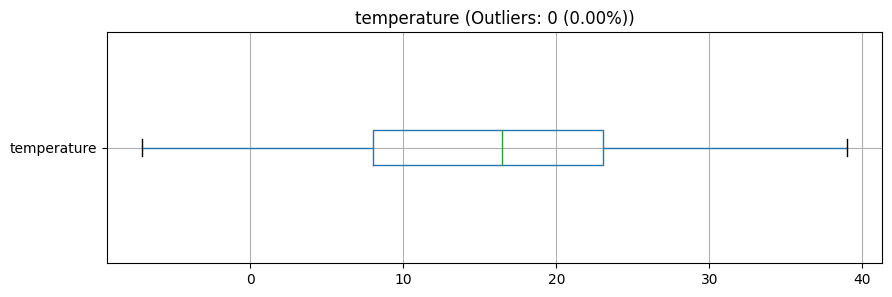

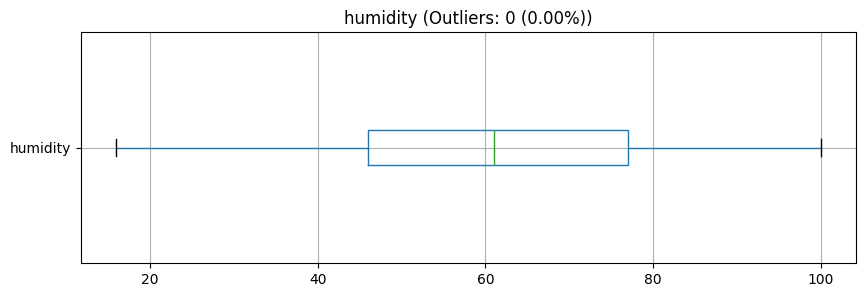

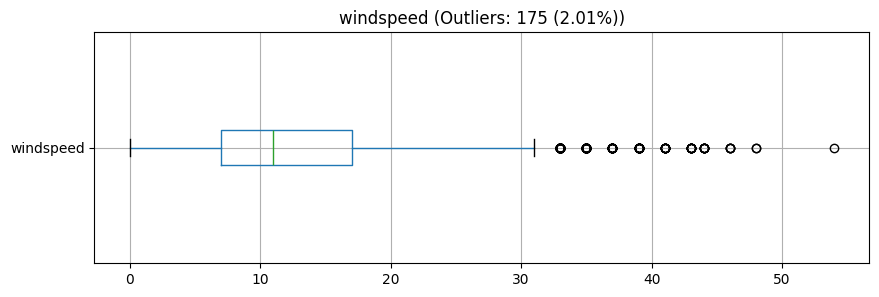

In [17]:
def box_plot_outlier(df, column, outlier_analysis_col=None):
    if column in df.columns:
        plt.figure(figsize=(10, 3))
        df.boxplot(column=column, vert=False)
        if outlier_analysis_col:
            plt.title(f'{column} (Outliers: {outlier_analysis_col["outlier_count"]} ({outlier_analysis_col["outlier_percentage"]:.2f}%))')
        else:
            plt.title(f'{column}')
        plt.show()

columns_to_inspect = list(outlier_analysis.keys())

for col in columns_to_inspect:
    box_plot_outlier(df_encoded, col, outlier_analysis[col])

In [18]:
df_len = df_encoded.shape[0]
df_without_outliers = df_encoded.copy()
for col, analysis in outlier_analysis.items():
    lower_bound = analysis['lower_bound']
    upper_bound = analysis['upper_bound']
    df_without_outliers = df_without_outliers[(df_without_outliers[col] >= lower_bound) & (df_without_outliers[col] <= upper_bound)]

print(f"Number of rows removed due to outliers: {df_len - df_without_outliers.shape[0]}")
df_without_outliers.shape

Number of rows removed due to outliers: 175


(8525, 10)

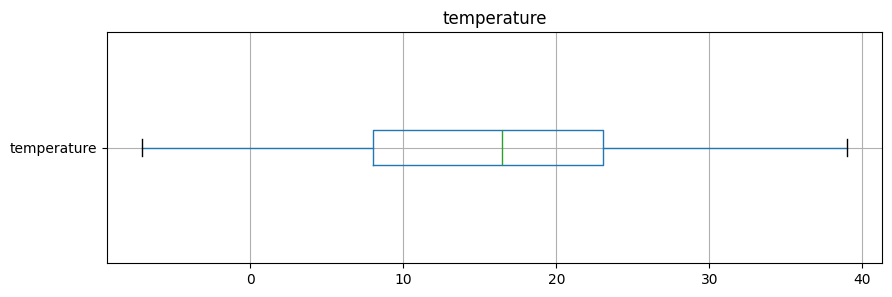

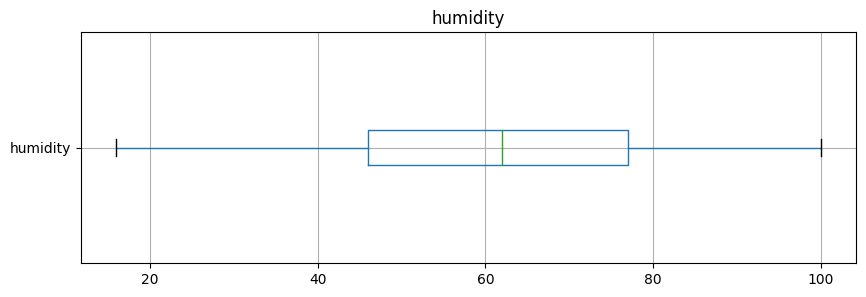

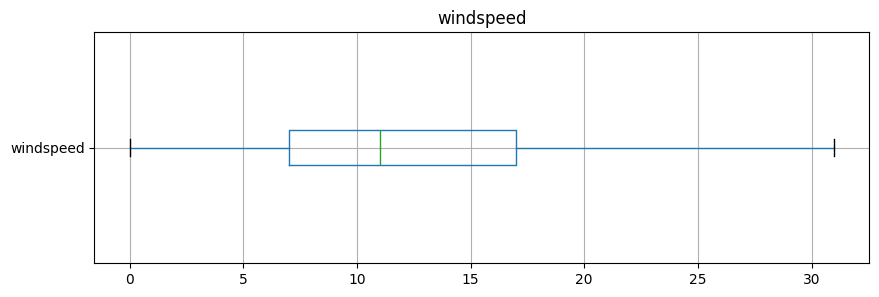

In [19]:
columns_to_inspect = list(outlier_analysis.keys())

for col in columns_to_inspect:
    box_plot_outlier(df_without_outliers, col)

## 2. Exploratory Data Analysis (EDA)

Understanding patterns in the data helps guide feature engineering and model selection:
- **Temporal patterns**: How do rentals vary by hour and month?
- **Day type effects**: Workdays vs weekends show different usage patterns
- **Weather impact**: Clear weather correlates with higher rentals
- **Seasonal trends**: Summer months show higher demand

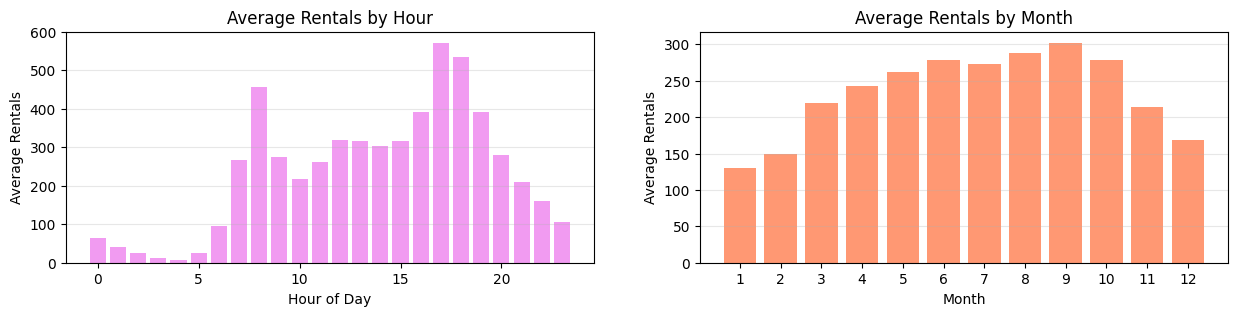

In [224]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
hourly_avg = df_without_outliers.groupby('hour')['count'].mean()
axes[0].bar(hourly_avg.index, hourly_avg.values, color='violet', alpha=0.8)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average Rentals')
axes[0].set_title('Average Rentals by Hour')
axes[0].grid(True, alpha=0.3, axis='y')

monthly_avg = df_without_outliers.groupby('month')['count'].mean()
axes[1].bar(monthly_avg.index, monthly_avg.values, color='coral', alpha=0.8)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Rentals')
axes[1].set_title('Average Rentals by Month')
axes[1].set_xticks(range(1, 13))
axes[1].grid(True, alpha=0.3, axis='y')

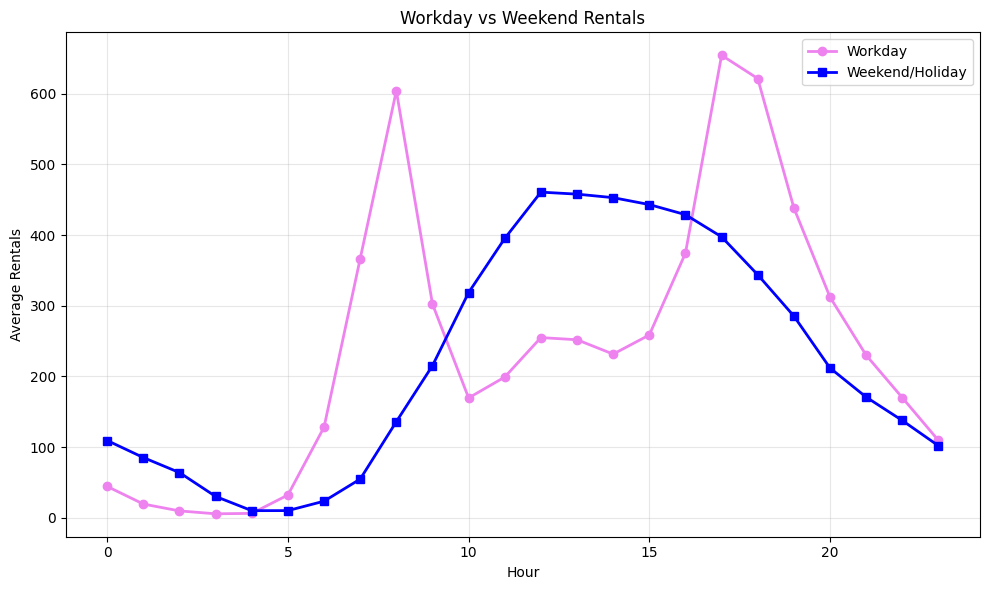

In [225]:
plt.figure(figsize=(10, 6))

workday_hourly = df_without_outliers[df_without_outliers['workingday'] == 1].groupby('hour')['count'].mean()
weekend_hourly = df_without_outliers[df_without_outliers['workingday'] == 0].groupby('hour')['count'].mean()

plt.plot(workday_hourly.index, workday_hourly.values, marker='o', label='Workday', linewidth=2, color='violet')
plt.plot(weekend_hourly.index, weekend_hourly.values, marker='s', label='Weekend/Holiday', linewidth=2, color='blue')
plt.xlabel('Hour')
plt.ylabel('Average Rentals')
plt.title('Workday vs Weekend Rentals')
plt.legend()
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

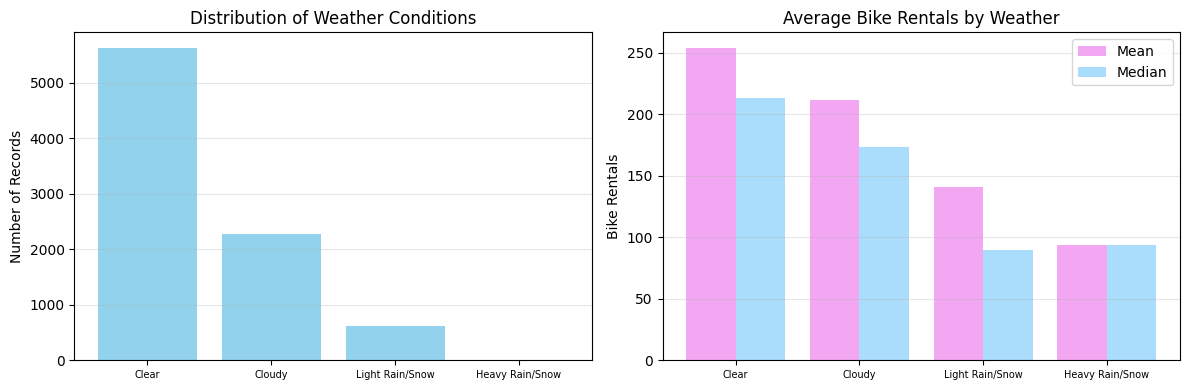

In [226]:
weather_names = {0: 'Clear', 1: 'Cloudy', 2: 'Light Rain/Snow', 3: 'Heavy Rain/Snow'}

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

weather_counts = df_without_outliers['weather'].value_counts().sort_index()
weather_labels = [weather_names[i] for i in weather_counts.index]
axes[0].bar(weather_labels, weather_counts.values, color='skyblue', alpha=0.9)
axes[0].set_ylabel('Number of Records')
axes[0].set_title('Distribution of Weather Conditions')
axes[0].tick_params(axis='x', labelsize=7)
axes[0].grid(True, alpha=0.3, axis='y')

weather_rentals = df_without_outliers.groupby('weather')['count'].agg(['mean', 'median', 'std'])
x_pos = range(len(weather_rentals))
axes[1].bar([i-0.2 for i in x_pos], weather_rentals['mean'], width=0.4, label='Mean', alpha=0.7, color='violet')
axes[1].bar([i+0.2 for i in x_pos], weather_rentals['median'], width=0.4, label='Median', alpha=0.7, color='lightskyblue')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([weather_names[i] for i in weather_rentals.index], fontsize=7)
axes[1].set_ylabel('Bike Rentals')
axes[1].set_title('Average Bike Rentals by Weather')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

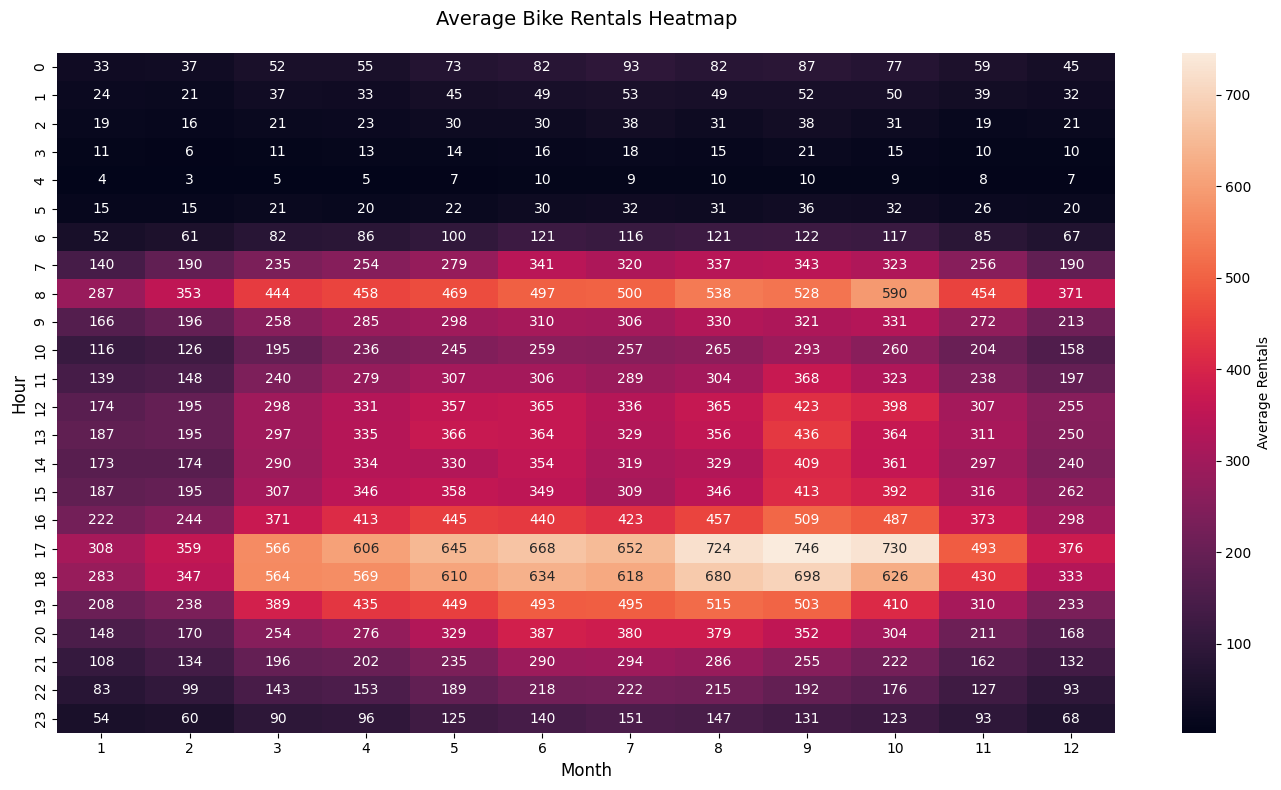

In [227]:
heatmap_data = df_without_outliers.pivot_table(
    values='count',
    index='hour',
    columns='month',
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cbar_kws={'label': 'Average Rentals'})
plt.title('Average Bike Rentals Heatmap', fontsize=14, pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Hour', fontsize=12)
plt.tight_layout()
plt.show()

In [171]:
peak_hours_table = Table(title="Peak Hours Analysis", show_header=True, header_style="bold magenta")
peak_hours_table.add_column("Category", style="cyan", width=20)
peak_hours_table.add_column("Peak Hour", justify="center")
peak_hours_table.add_column("Avg Rentals", justify="right")

overall_peak = df_without_outliers.groupby('hour')['count'].mean()
peak_hour = overall_peak.idxmax()
peak_hours_table.add_row(
    "All",
    str(peak_hour),
    f"{overall_peak[peak_hour]:.1f}",
)

workday_peak = df_without_outliers[df_without_outliers['workingday'] == 1].groupby('hour')['count'].mean()
peak_hour_wd = workday_peak.idxmax()
peak_hours_table.add_row(
    "Workday",
    str(peak_hour_wd),
    f"{workday_peak[peak_hour_wd]:.1f}",
)

weekend_peak = df_without_outliers[df_without_outliers['workingday'] == 0].groupby('hour')['count'].mean()
peak_hour_we = weekend_peak.idxmax()
peak_hours_table.add_row(
    "Weekend/Holiday",
    str(peak_hour_we),
    f"{weekend_peak[peak_hour_we]:.1f}",
)

rprint(peak_hours_table)

               Peak Hours Analysis                
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Category             ┃ Peak Hour ┃ Avg Rentals ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ All                  │    17     │       571.7 │
│ Workday              │    17     │       654.4 │
│ Weekend/Holiday      │    12     │       460.7 │
└──────────────────────┴───────────┴─────────────┘

## 3. Train-Test Split and Feature Scaling

We split data into 80% training and 20% test sets with a fixed random seed for reproducibility.

**StandardScaler** is applied to normalize features, which is important for:
- SVM models (sensitive to feature scales)
- Neural networks (faster convergence)
- Fair comparison across features

In [20]:
X = df_without_outliers.drop(columns=['count'])
y = df_without_outliers['count']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (6820, 9), Test shape: (1705, 9)


#### 3.1 Scaling features

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Model Training and Evaluation

We train multiple regression models and compare their performance using:
- **R² Score**: Proportion of variance explained (higher is better)
- **RMSE**: Root Mean Squared Error (lower is better)
- **MAE**: Mean Absolute Error (lower is better)

All models use the same random seed for fair comparison.

In [22]:
best_models = {}

### 4.1 Decision Tree Regressor

Decision Trees split data based on feature values to minimize prediction error. We tune the `max_depth` parameter to prevent overfitting.

**Hyperparameter Tuning**: Testing max_depth from 1 to 100 to find optimal complexity

In [23]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [24]:
best = {
    "r2": -np.inf,
    "max_depth": None,
}

for i in range(1, 100):
    model = DecisionTreeRegressor(max_depth=i, random_state=RANDOM_SEED)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)

    if r2 > best["r2"]:
        best["r2"] = r2
        best["max_depth"] = i

rprint(f"Best max_depth: {best['max_depth']} with R2: {best['r2']:.4f}")

Best max_depth: 10 with R2: 0.8891

In [25]:
dt = DecisionTreeRegressor(max_depth=best["max_depth"], random_state=RANDOM_SEED)
dt.fit(X_train_scaled, y_train)
best_models["Decision Tree"] = dt

In [26]:
max_depths = list(range(1, 11))
results = {
    "R2 score": [],
    "Number of nodes": [],
    "Number of leaves": [],
    "Height": []
}

for i in max_depths:
    tree_reg = DecisionTreeRegressor(max_depth=i, random_state=RANDOM_SEED)
    tree_reg.fit(X_train_scaled, y_train)
    y_pred = tree_reg.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    results["R2 score"].append(f"{r2:.3f}")
    results["Number of nodes"].append(str(tree_reg.tree_.node_count))
    results["Number of leaves"].append(str(tree_reg.get_n_leaves()))
    results["Height"].append(str(tree_reg.get_depth()))

table = Table(show_header=True, header_style="bold green")
table.add_column("Tree max_depth=", style="dim", width=22)
for i in max_depths:
    table.add_column(str(i), justify="right")

# for metric in results:
    # table.add_row(metric, *results[metric])

for metric in results:
    row = []
    for idx, val in enumerate(results[metric]):
        if idx == len(results[metric]) - 1:
            row.append(f"[bold yellow]{val}[/bold yellow]")
        else:
            row.append(val)
    table.add_row(metric, *row)

rprint(table)

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Tree max_depth=        ┃     1 ┃     2 ┃     3 ┃     4 ┃     5 ┃     6 ┃     7 ┃     8 ┃     9 ┃    10 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ R2 score               │ 0.353 │ 0.438 │ 0.525 │ 0.603 │ 0.649 │ 0.775 │ 0.848 │ 0.868 │ 0.885 │ 0.889 │
│ Number of nodes        │     3 │     7 │    15 │    31 │    63 │   127 │   253 │   489 │   911 │  1611 │
│ Number of leaves       │     2 │     4 │     8 │    16 │    32 │    64 │   127 │   245 │   456 │   806 │
│ Height                 │     1 │     2 │     3 │     4 │     5 │     6 │     7 │     8 │     9 │    10 │
└────────────────────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┘

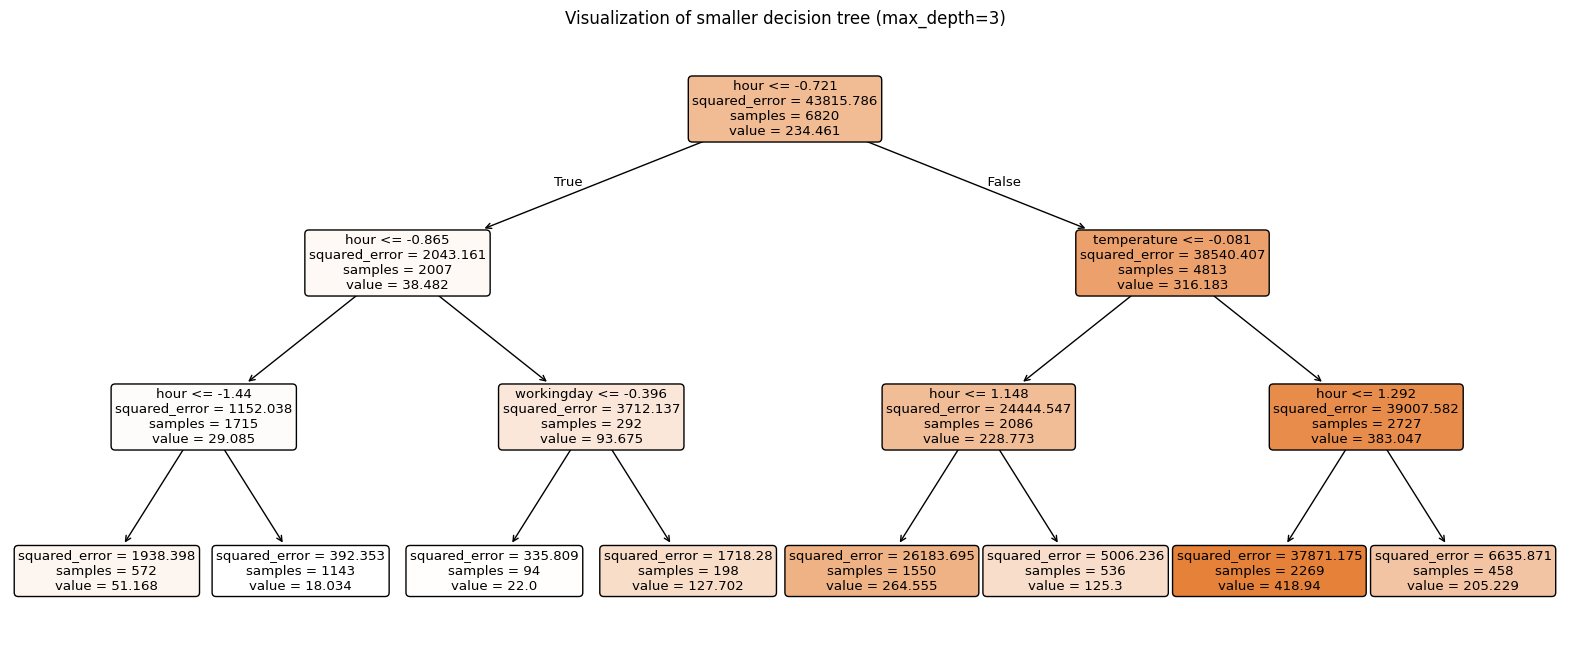

Small decision tree R2 score: 0.525


In [27]:
small_tree = DecisionTreeRegressor(max_depth=3, random_state=RANDOM_SEED)
small_tree.fit(X_train_scaled, y_train)

plt.figure(figsize=(20, 8))
plot_tree(
    small_tree,
    feature_names=X.columns,
    filled=True,
    rounded=True,
)
plt.title("Visualization of smaller decision tree (max_depth=3)")
plt.show()

y_small_pred = small_tree.predict(X_test_scaled)
r2_small = r2_score(y_test, y_small_pred)
print(f"Small decision tree R2 score: {r2_small:.3f}")

### 4.2 Random Forest Regressor

Random Forest builds multiple decision trees on random subsets of data and features, then averages their predictions. This reduces overfitting and typically provides better generalization.

**Ensemble Method**: Combines 10 trees to improve stability and accuracy
**Feature Importance**: Can identify which features contribute most to predictions

In [28]:
from sklearn.ensemble import RandomForestRegressor

Random Forest R2 score: 0.925


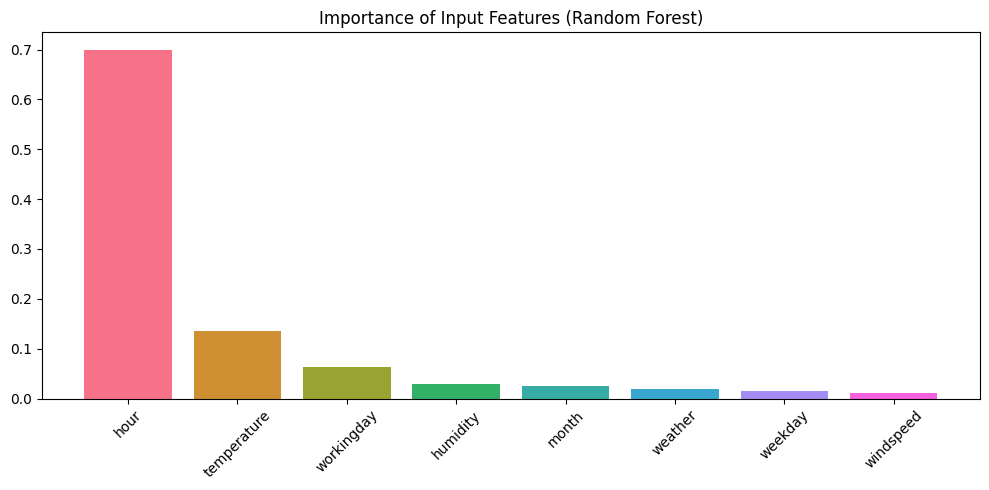

In [29]:
random_forest = RandomForestRegressor(n_estimators=10, random_state=RANDOM_SEED)
random_forest.fit(X_train_scaled, y_train)
y_pred_rf = random_forest.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest R2 score: {r2_rf:.3f}")

feature_importances = random_forest.feature_importances_
indices = np.argsort(feature_importances)[::-1]

top_n = 8
colors = sns.color_palette("husl", top_n)

plt.figure(figsize=(10, 5))
plt.title("Importance of Input Features (Random Forest)")
plt.bar(range(top_n), feature_importances[indices][:top_n], align="center", color=colors)
plt.xticks(range(top_n), [X.columns[i] for i in indices[:top_n]], rotation=45)
plt.tight_layout()
plt.show()

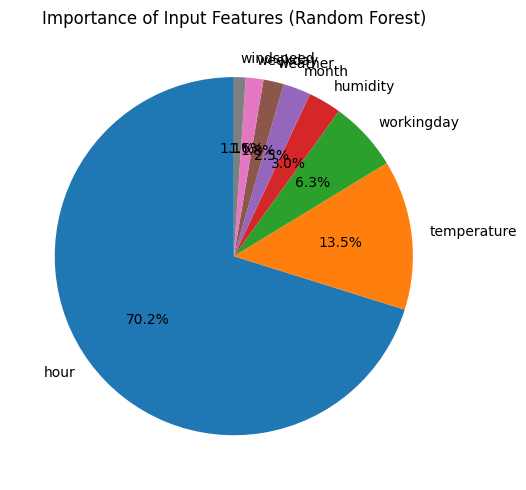

In [30]:
plt.figure(figsize=(10, 5))
plt.title("Importance of Input Features (Random Forest)")
plt.pie(
    sorted(feature_importances[indices][:top_n], reverse=True),
    labels=[X.columns[i] for i in indices[:top_n]],
    autopct="%1.1f%%",
    startangle=90,
)
plt.tight_layout()
plt.show()

In [31]:
print(sorted(feature_importances.round(2), reverse=True))
print(sum(feature_importances).round(2))

[0.7, 0.13, 0.06, 0.03, 0.02, 0.02, 0.02, 0.01, 0.0]
1.0


In [32]:
rf = RandomForestRegressor(n_estimators=10, random_state=RANDOM_SEED)
rf.fit(X_train_scaled, y_train)
best_models["Random Forest"] = rf

### 4.3 Support Vector Machine (SVM)

SVM with RBF kernel can capture non-linear relationships in the data. It finds the optimal hyperplane that minimizes prediction error.

**Kernel**: RBF (Radial Basis Function) for non-linear patterns
**Regularization**: C=100 controls the trade-off between smooth function and training accuracy

In [33]:
from sklearn.svm import SVR

In [34]:
svm = SVR(kernel='rbf', C=100)
svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_scaled)
r2_svm = r2_score(y_test, y_pred_svm)

print(f"SVM R2 score: {r2_svm:.3f}")

SVM R2 score: 0.554


In [35]:
svm = SVR(kernel='rbf', C=100)
svm.fit(X_train_scaled, y_train)
best_models["SVM"] = svm

### 4.4 Model Comparison and Evaluation

Comprehensive evaluation of all trained models including:
- **Training vs Test Performance**: Checking for overfitting
- **Residual Analysis**: Examining prediction errors
- **Visual Comparison**: Bar charts and scatter plots
- **Error Distribution**: Percentage error statistics

The best model is selected based on test set performance.

In [36]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Train metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, y_train_pred)

    # Test metrics
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    # Residuals
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    return {
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'train_pred': y_train_pred,
        'test_pred': y_test_pred,
        'train_residuals': train_residuals,
        'test_residuals': test_residuals
    }

In [37]:
results = {}
for name, model in best_models.items():
    results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    print(f"Evaluation done for: {name}")


Evaluation done for: Decision Tree
Evaluation done for: Random Forest
Evaluation done for: SVM


In [38]:
comparison_table = Table(title="Model Comparison", show_header=True, header_style="bold magenta")
comparison_table.add_column("Model", style="cyan", width=20)
comparison_table.add_column("Train R2", justify="right")
comparison_table.add_column("Test R2", justify="right")
comparison_table.add_column("Train RMSE", justify="right")
comparison_table.add_column("Test RMSE", justify="right")
comparison_table.add_column("Train MSE", justify="right")
comparison_table.add_column("Test MSE", justify="right")

for name, res in results.items():
    comparison_table.add_row(
        name,
        f"{res['train_r2']:.3f}",
        f"{res['test_r2']:.3f}",
        f"{res['train_rmse']:.2f}",
        f"{res['test_rmse']:.2f}",
        f"{res['train_mse']:.2f}",
        f"{res['test_mse']:.2f}"
    )

rprint(comparison_table)

                                      Model Comparison                                       
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Model                ┃ Train R2 ┃ Test R2 ┃ Train RMSE ┃ Test RMSE ┃ Train MSE ┃ Test MSE ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Decision Tree        │    0.950 │   0.889 │      46.80 │     69.17 │   2189.81 │  4784.76 │
│ Random Forest        │    0.989 │   0.925 │      22.22 │     57.00 │    493.87 │  3249.53 │
│ SVM                  │    0.579 │   0.554 │     135.81 │    138.77 │  18443.19 │ 19258.26 │
└──────────────────────┴──────────┴─────────┴────────────┴───────────┴───────────┴──────────┘

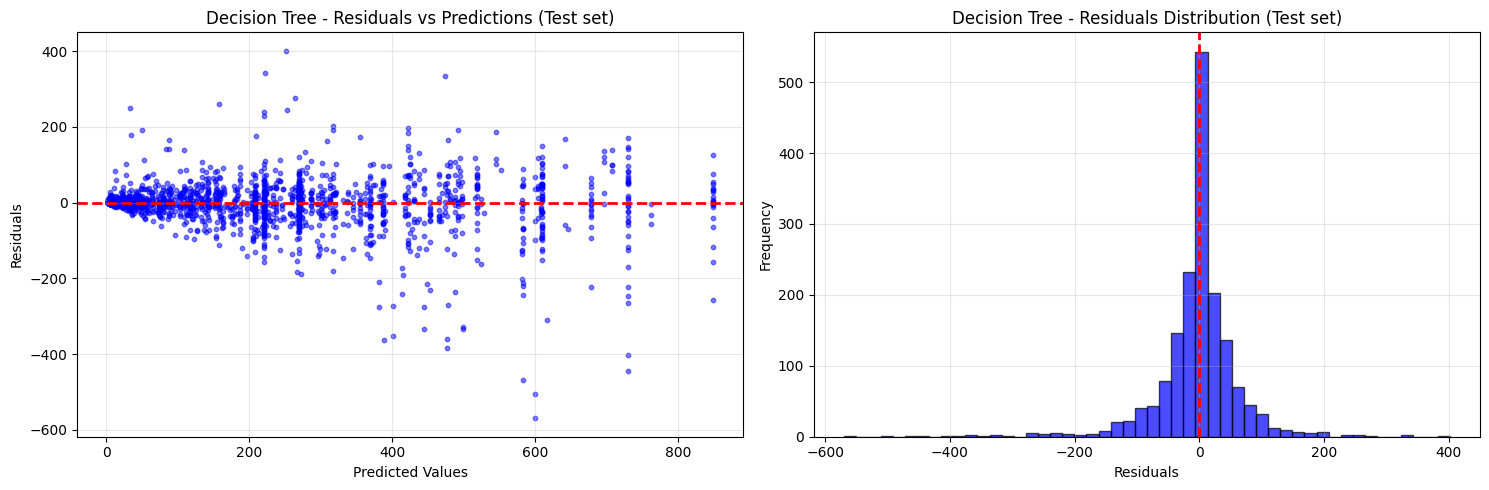

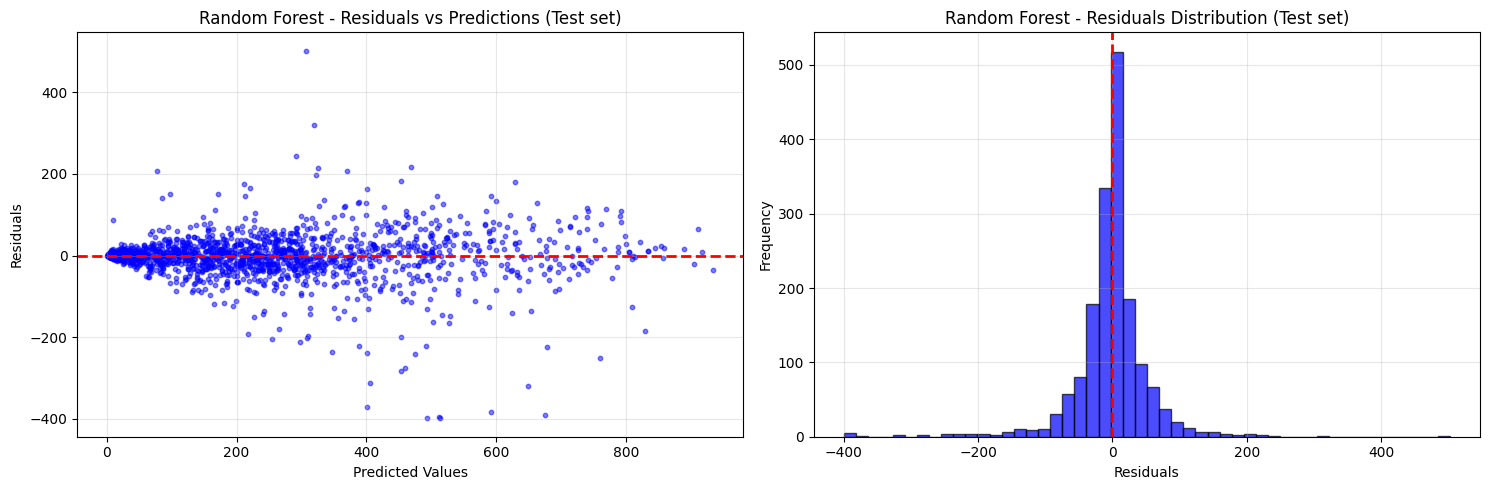

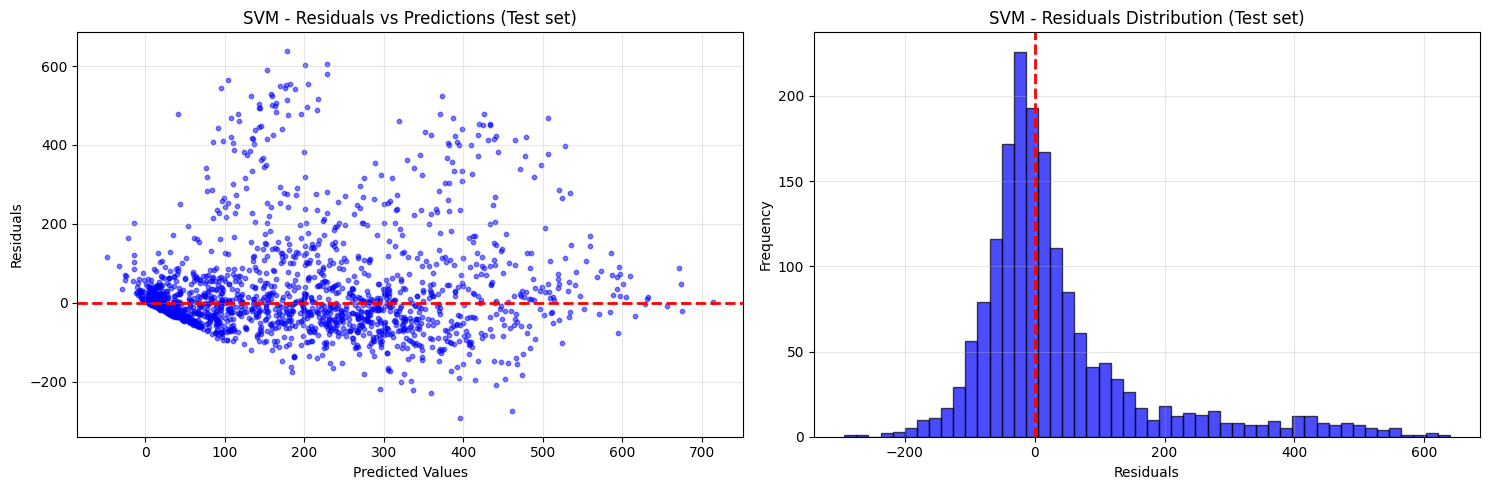

In [39]:
for name, res in results.items():
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Residuals vs predicted
    axes[0].scatter(res['test_pred'], res['test_residuals'], alpha=0.5, s=10, color='b')
    axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Predicted Values')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title(f'{name} - Residuals vs Predictions (Test set)')
    axes[0].grid(True, alpha=0.3)

    # Residuals histogram
    axes[1].hist(res['test_residuals'], bins=50, edgecolor='black', alpha=0.7, color='b')
    axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Residuals')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{name} - Residuals Distribution (Test set)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

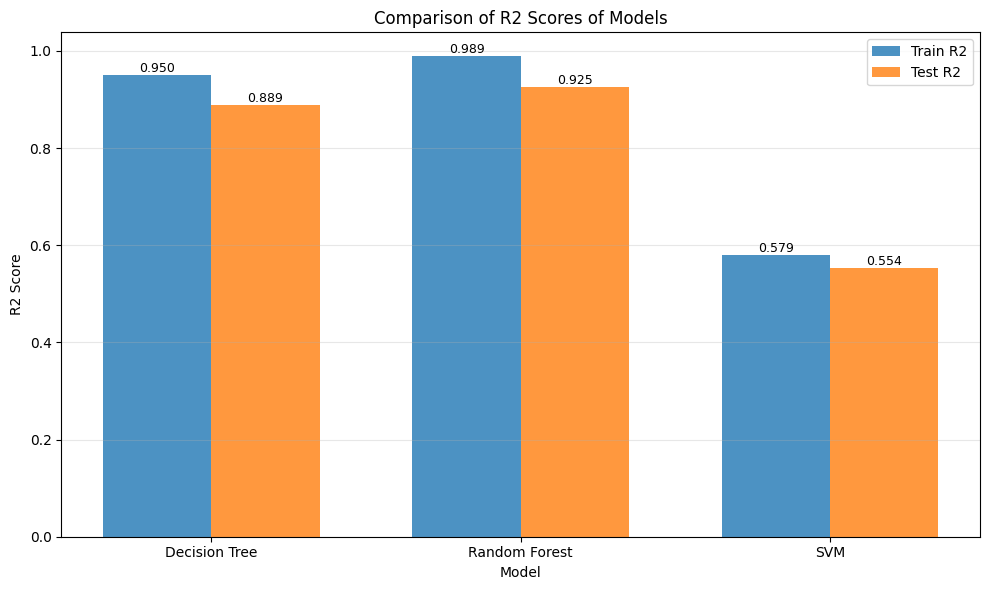

In [40]:
model_names = list(results.keys())
train_r2_scores = [results[name]['train_r2'] for name in model_names]
test_r2_scores = [results[name]['test_r2'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, train_r2_scores, width, label='Train R2', alpha=0.8)
bars2 = ax.bar(x + width/2, test_r2_scores, width, label='Test R2', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('R2 Score')
ax.set_title('Comparison of R2 Scores of Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

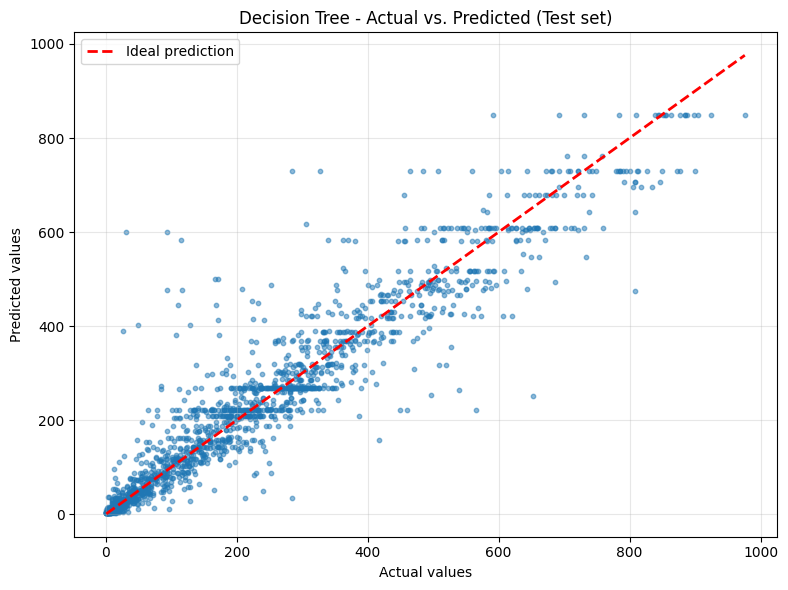

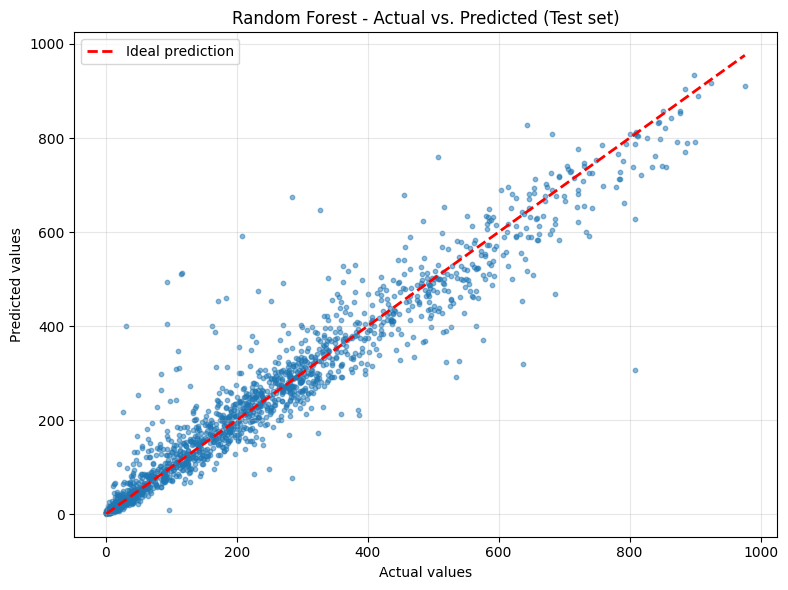

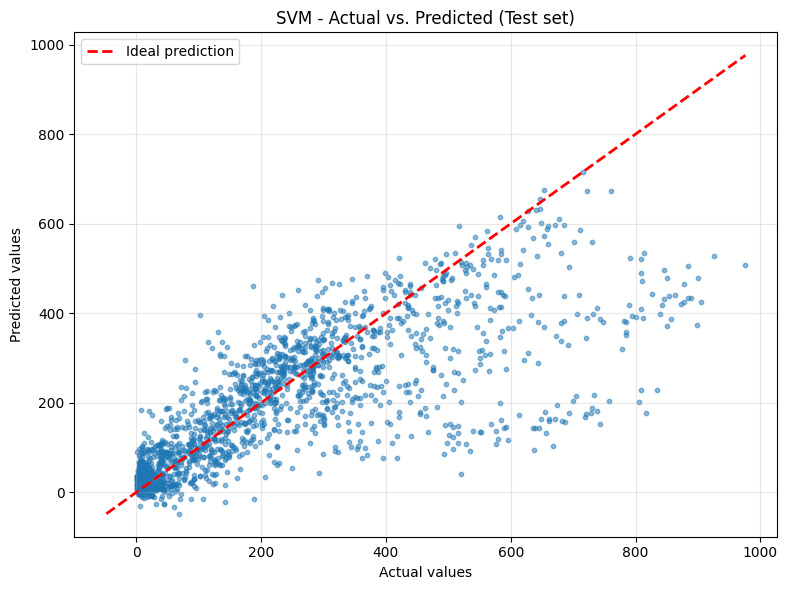

In [41]:
for name, res in results.items():
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, res['test_pred'], alpha=0.5, s=10)

    min_val = min(y_test.min(), res['test_pred'].min())
    max_val = max(y_test.max(), res['test_pred'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal prediction')

    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.title(f'{name} - Actual vs. Predicted (Test set)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [42]:
for name, res in results.items():
    test_errors = np.abs(res['test_residuals'])
    test_pct_errors = (test_errors / y_test) * 100

    print(f"\n{name} - Percentual error:")
    print(f"  Median error: {np.median(test_pct_errors):.2f}%")
    print(f"  Average error: {np.mean(test_pct_errors):.2f}%")
    print(f"  Error < 10%: {(test_pct_errors < 10).sum() / len(test_pct_errors) * 100:.1f}% samples")
    print(f"  Error < 20%: {(test_pct_errors < 20).sum() / len(test_pct_errors) * 100:.1f}% samples")


Decision Tree - Percentual error:
  Median error: 14.92%
  Average error: 34.00%
  Error < 10%: 36.1% samples
  Error < 20%: 59.4% samples

Random Forest - Percentual error:
  Median error: 12.56%
  Average error: 28.53%
  Error < 10%: 41.5% samples
  Error < 20%: 66.7% samples

SVM - Percentual error:
  Median error: 37.61%
  Average error: 111.16%
  Error < 10%: 16.8% samples
  Error < 20%: 31.8% samples


## 5. Dimensionality Reduction and Feature Selection

Exploring whether we can maintain performance with fewer features:
- **PCA (Principal Component Analysis)**: Linear combinations of features
- **Feature Importance**: Based on Random Forest
- **Correlation Analysis**: Selecting highly correlated features

This can lead to:
- Faster training and prediction
- Reduced overfitting
- Better model interpretability

In [43]:
from sklearn.decomposition import PCA

In [44]:
all_features = X.columns.tolist()
all_features

['month',
 'hour',
 'holiday',
 'weekday',
 'workingday',
 'weather',
 'temperature',
 'humidity',
 'windspeed']

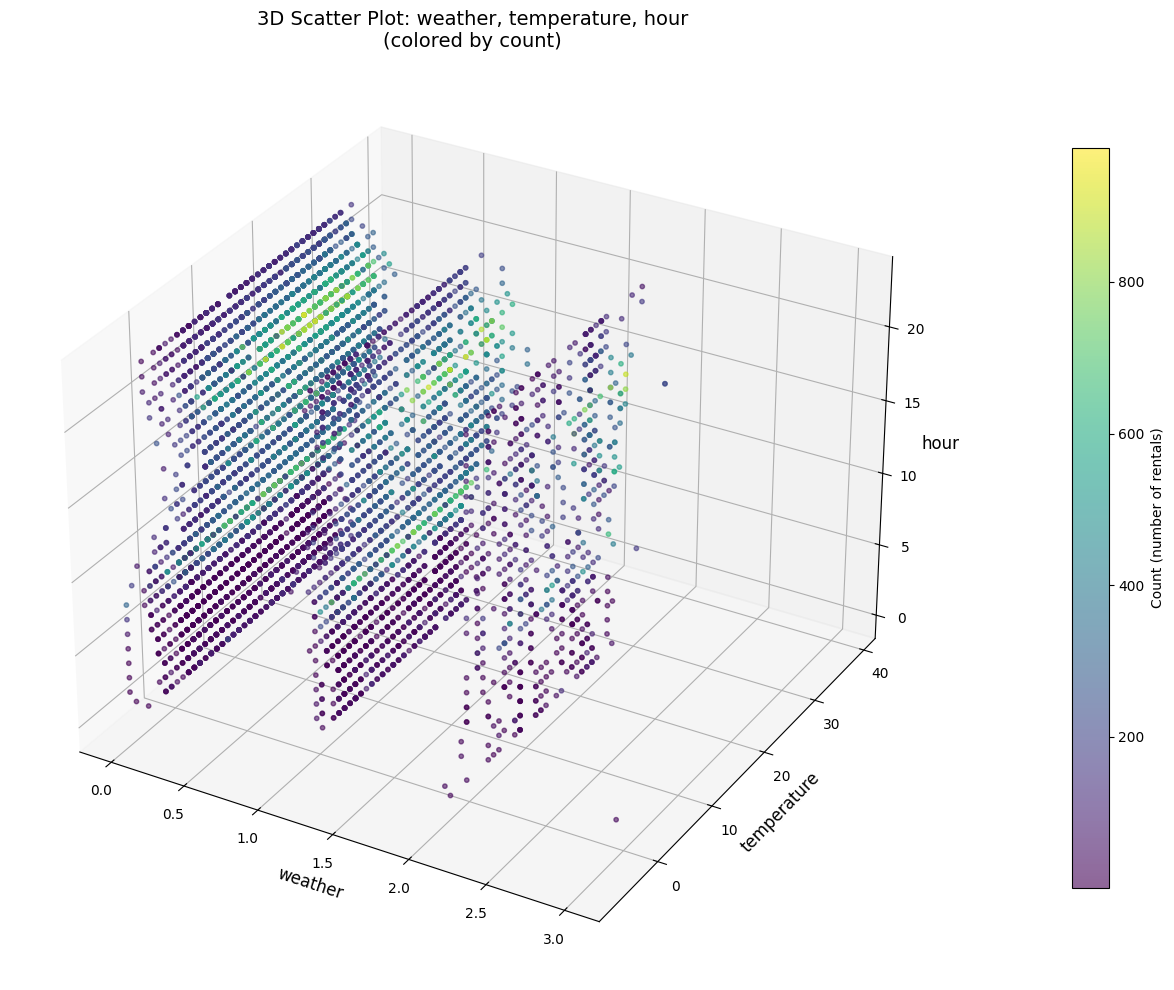

In [45]:
selected_features = ['weather', 'temperature', 'hour']

X_original = df_without_outliers[selected_features]
y_original = df_without_outliers['count']

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_original[selected_features[0]],
    X_original[selected_features[1]],
    X_original[selected_features[2]],
    c=y_original,
    cmap='viridis',
    s=10,
    alpha=0.6
)

ax.set_xlabel(selected_features[0], fontsize=12)
ax.set_ylabel(selected_features[1], fontsize=12)
ax.set_zlabel(selected_features[2], fontsize=12)
ax.set_title(f'3D Scatter Plot: {selected_features[0]}, {selected_features[1]}, {selected_features[2]}\n(colored by count)', fontsize=14)

cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Count (number of rentals)', fontsize=10)

plt.tight_layout()
plt.show()

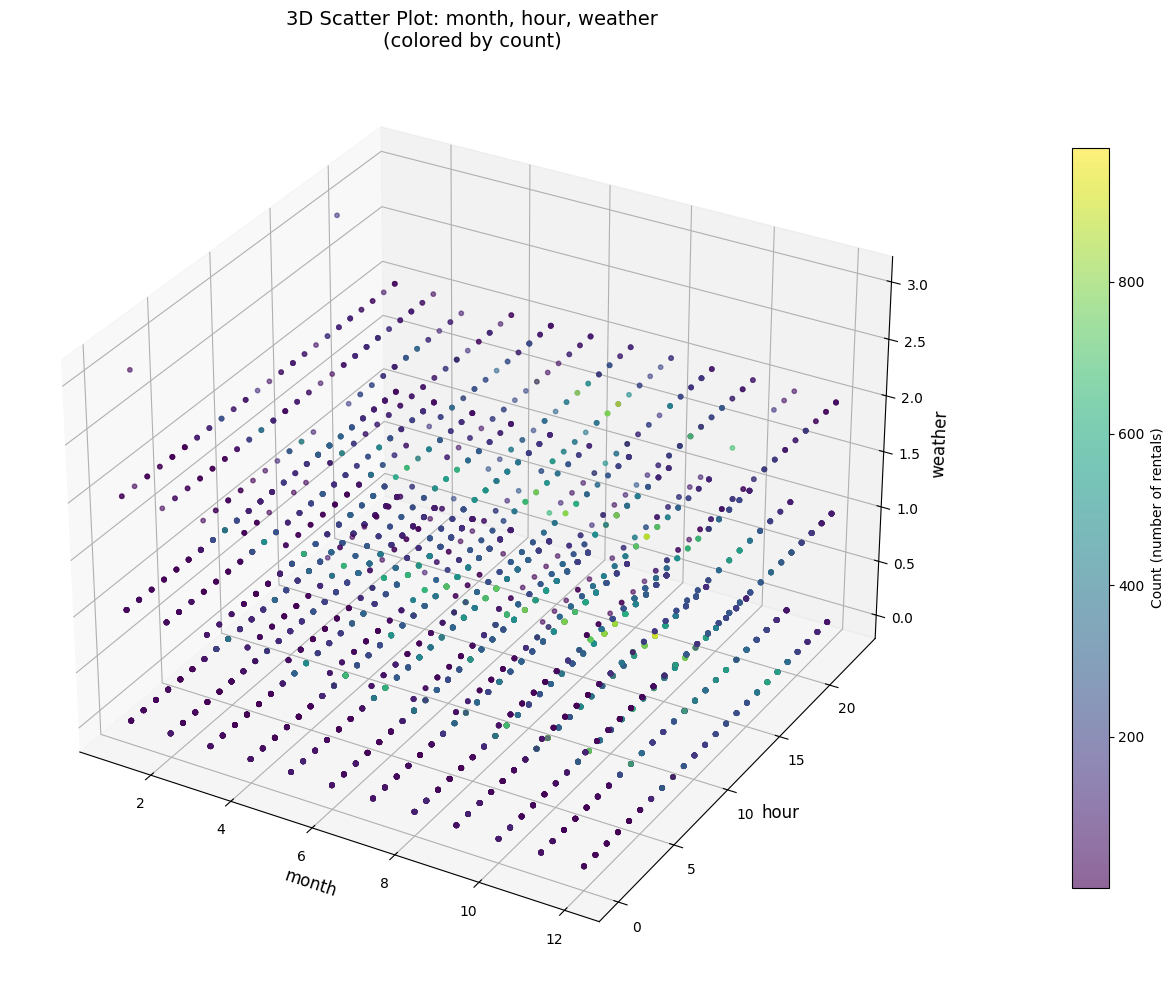

In [46]:
selected_features = ['month', 'hour', 'weather',]

X_original = df_without_outliers[selected_features]
y_original = df_without_outliers['count']

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_original[selected_features[0]],
    X_original[selected_features[1]],
    X_original[selected_features[2]],
    c=y_original,
    s=10,
    alpha=0.6
)

ax.set_xlabel(selected_features[0], fontsize=12)
ax.set_ylabel(selected_features[1], fontsize=12)
ax.set_zlabel(selected_features[2], fontsize=12)
ax.set_title(f'3D Scatter Plot: {selected_features[0]}, {selected_features[1]}, {selected_features[2]}\n(colored by count)', fontsize=14)

cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Count (number of rentals)', fontsize=10)

plt.tight_layout()
plt.show()

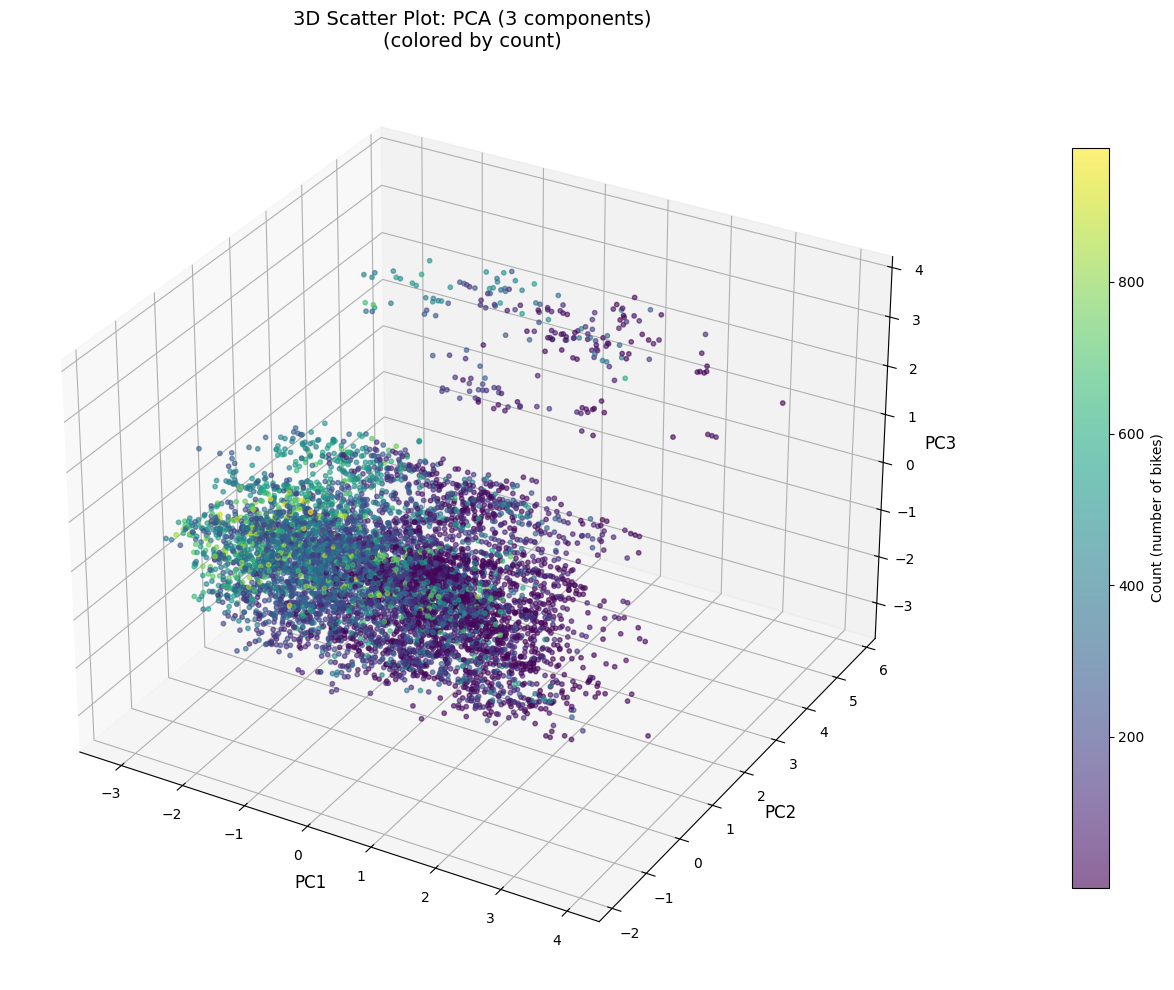

In [47]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scaled)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=y_train,
    s=10,
    alpha=0.6
)

ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_zlabel('PC3', fontsize=12)
ax.set_title('3D Scatter Plot: PCA (3 components)\n(colored by count)', fontsize=14)

cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Count (number of bikes)', fontsize=10)

plt.tight_layout()
plt.show()

In [48]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scaled)

loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=X.columns
)
print("PCA Loadings:")
print(loadings)

PCA Loadings:
                  PC1       PC2       PC3
month        0.130784 -0.131586  0.633178
hour        -0.411996 -0.086870  0.097372
holiday     -0.020315  0.619454  0.268816
weekday     -0.033548 -0.359224 -0.041277
workingday   0.030117 -0.593797 -0.205516
weather      0.452452 -0.018495 -0.195384
temperature -0.221593 -0.299998  0.546778
humidity     0.651951 -0.012019  0.069818
windspeed   -0.363116  0.138901 -0.362471


In [49]:
explained_var = pca.explained_variance_ratio_
print(f"PC1: {explained_var[0]*100:.1f} %")
print(f"PC2: {explained_var[1]*100:.1f} %")
print(f"PC3: {explained_var[2]*100:.1f} %")
print(f"Total: {explained_var.sum()*100:.1f} % variability covered by the first three components")

PC1: 19.2 %
PC2: 14.9 %
PC3: 13.2 %
Total: 47.3 % variability covered by the first three components


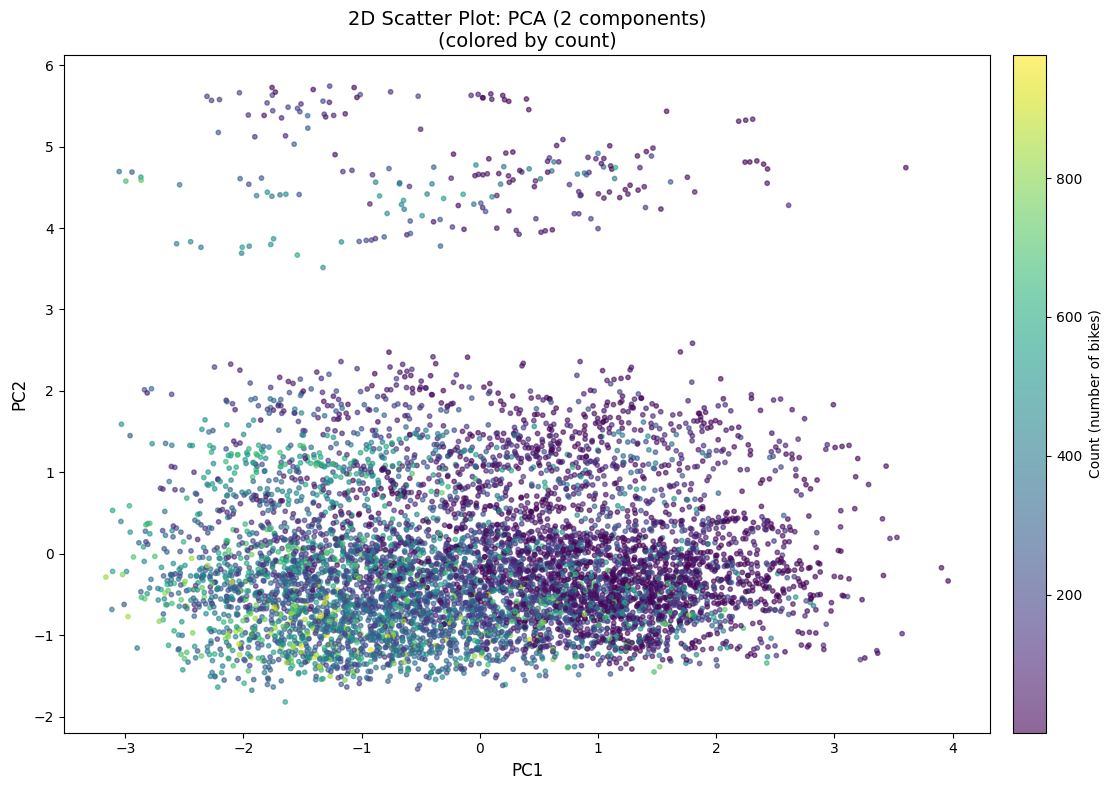

In [50]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y_train,
    s=10,
    alpha=0.6
)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('2D Scatter Plot: PCA (2 components)\n(colored by count)', fontsize=14)
cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label('Count (number of bikes)', fontsize=10)
plt.tight_layout()
plt.show()

## 5. Subset of features

In [51]:
MODEL_DICT = {
    "Decision Tree": best_models["Decision Tree"],
    "Random Forest": best_models["Random Forest"],
    "SVM": best_models["SVM"],
}

model_name = "Random Forest"

#### 5.1 Feature Selection by Correlation Matrix


Correlation with target 'count':
count          1.000000
hour           0.426720
temperature    0.395926
humidity       0.350897
weather        0.151013
windspeed      0.127449
month          0.099781
weekday        0.051853
workingday     0.044633
holiday        0.041561
Name: count, dtype: float64


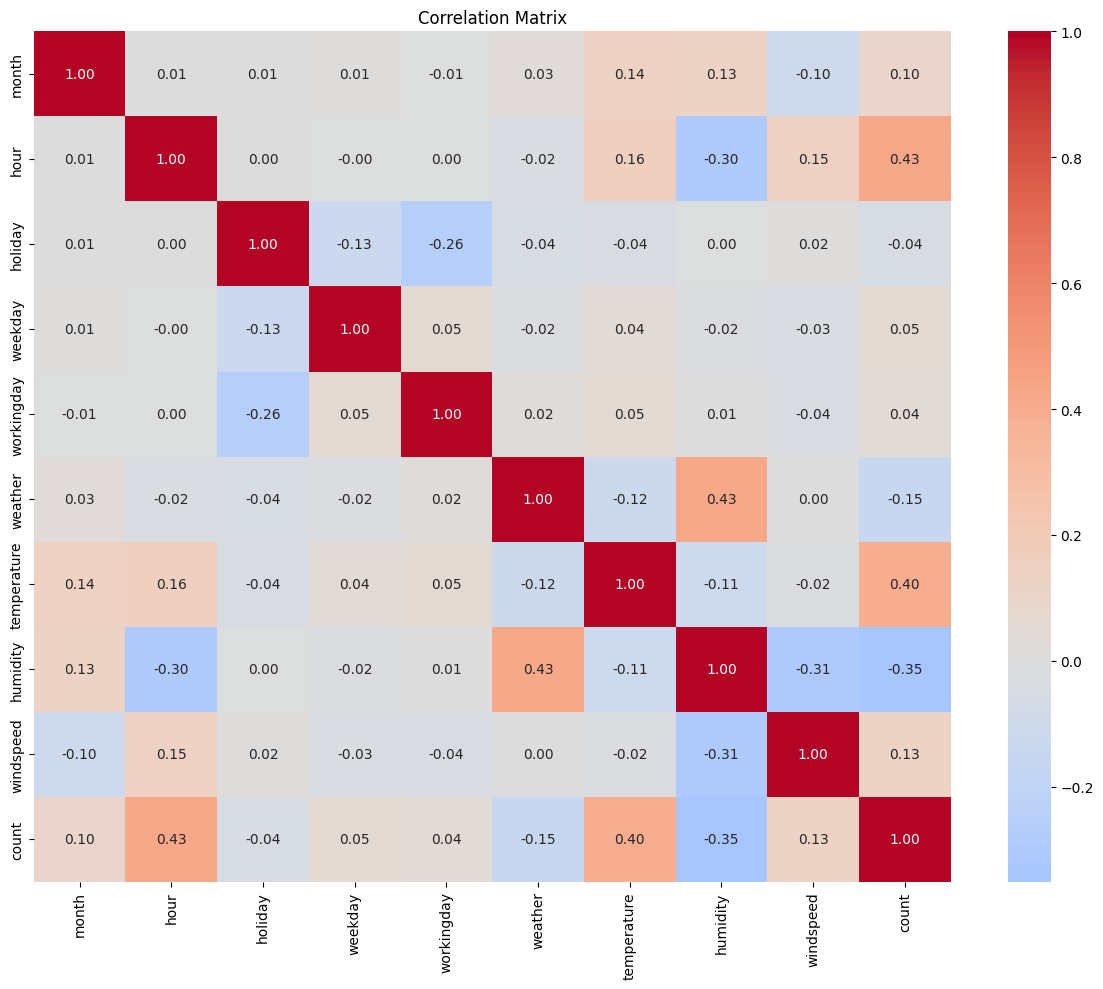

In [52]:
correlation_matrix = df_without_outliers.corr()

target_correlation = correlation_matrix['count'].abs().sort_values(ascending=False)
print("\nCorrelation with target 'count':")
print(target_correlation)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [53]:
correlation_threshold = 0.1
selected_features_corr = target_correlation[target_correlation > correlation_threshold].index.tolist()
selected_features_corr.remove('count')
print(f"\nSelected features by correlation (threshold={correlation_threshold}): {selected_features_corr}")


Selected features by correlation (threshold=0.1): ['hour', 'temperature', 'humidity', 'weather', 'windspeed']


In [54]:
X_train_corr = X_train[selected_features_corr]
X_test_corr = X_test[selected_features_corr]

scaler_corr = StandardScaler()
X_train_corr_scaled = scaler_corr.fit_transform(X_train_corr)
X_test_corr_scaled = scaler_corr.transform(X_test_corr)

model_corr = MODEL_DICT[model_name]

model_corr.fit(X_train_corr_scaled, y_train)
results_corr = evaluate_model(model_corr, X_train_corr_scaled, X_test_corr_scaled, y_train, y_test)

print(f"  Number of features: {len(selected_features_corr)}")
print(f"  Train R2: {results_corr['train_r2']:.3f}")
print(f"  Test R2: {results_corr['test_r2']:.3f}")
print(f"  Test RMSE: {results_corr['test_rmse']:.2f}")

  Number of features: 5
  Train R2: 0.947
  Test R2: 0.694
  Test RMSE: 114.86


#### 5.2 Feature Selection by Feature Importance (from Random Forest)

In [55]:
rf_for_importance = RandomForestRegressor(n_estimators=50, random_state=RANDOM_SEED)
rf_for_importance.fit(X_train_scaled, y_train)

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_for_importance.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importances from Random Forest:")
print(feature_importances)


Feature Importances from Random Forest:
       feature  importance
1         hour    0.698471
6  temperature    0.134675
4   workingday    0.066983
7     humidity    0.028896
0        month    0.023992
5      weather    0.017661
3      weekday    0.016251
8    windspeed    0.010018
2      holiday    0.003052


In [56]:
cumsum_importance = feature_importances['importance'].cumsum()
threshold = 0.9
n_features_importance = (cumsum_importance <= threshold).sum() + 1
selected_features_importance = feature_importances['feature'].head(n_features_importance).tolist()

print(f"\nSelected features by importance (top {n_features_importance} features, cumulative importance > {threshold*100}%): {selected_features_importance}")

X_train_imp = X_train[selected_features_importance]
X_test_imp = X_test[selected_features_importance]

scaler_imp = StandardScaler()
X_train_imp_scaled = scaler_imp.fit_transform(X_train_imp)
X_test_imp_scaled = scaler_imp.transform(X_test_imp)

model_imp = MODEL_DICT[model_name]

model_imp.fit(X_train_imp_scaled, y_train)
results_imp = evaluate_model(model_imp, X_train_imp_scaled, X_test_imp_scaled, y_train, y_test)

print(f"  Number of features: {len(selected_features_importance)}")
print(f"  Train R2: {results_imp['train_r2']:.3f}")
print(f"  Test R2: {results_imp['test_r2']:.3f}")
print(f"  Test RMSE: {results_imp['test_rmse']:.2f}")


Selected features by importance (top 3 features, cumulative importance > 90.0%): ['hour', 'temperature', 'workingday']
  Number of features: 3
  Train R2: 0.913
  Test R2: 0.839
  Test RMSE: 83.30


#### 5.3 Feature Selection by PCA (based on variance)


In [57]:
variance_threshold = 0.9
pca_variance = PCA(n_components=variance_threshold, random_state=RANDOM_SEED)
X_train_pca = pca_variance.fit_transform(X_train_scaled)
X_test_pca = pca_variance.transform(X_test_scaled)

print(f"\nPCA with {variance_threshold*100}% variance:")
print(f"Number of components: {pca_variance.n_components_}")
print(f"Explained variance ratio: {pca_variance.explained_variance_ratio_}")
print(f"Cumulative explained variance: {pca_variance.explained_variance_ratio_.cumsum()[-1]:.3f}")


PCA with 90.0% variance:
Number of components: 8
Explained variance ratio: [0.19193503 0.14885097 0.13230031 0.11678804 0.10571907 0.09181425
 0.08471289 0.08091676]
Cumulative explained variance: 0.953


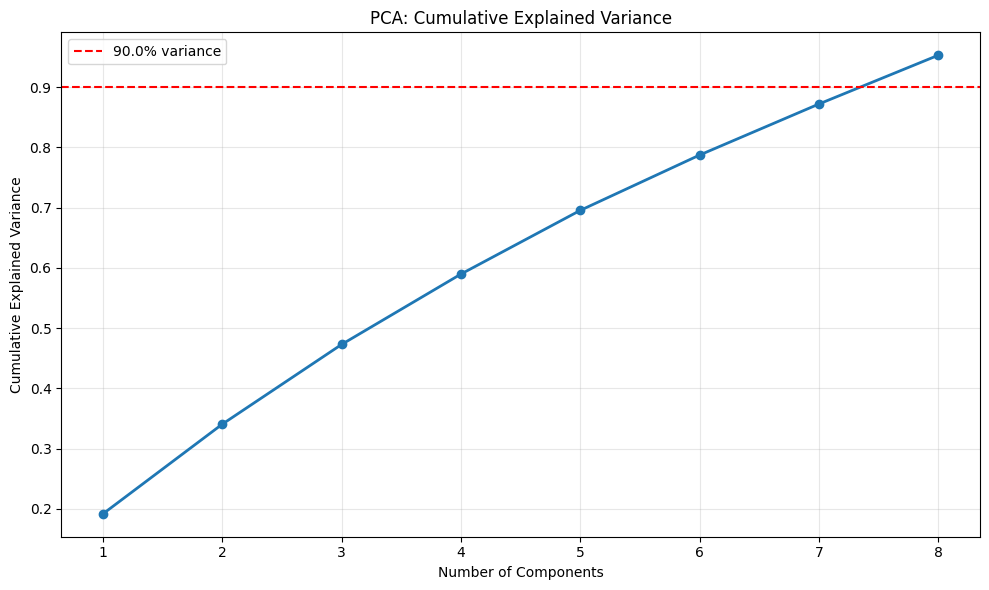

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_variance.explained_variance_ratio_) + 1),
         pca_variance.explained_variance_ratio_.cumsum(),
         marker='o', linestyle='-', linewidth=2)
plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{variance_threshold*100}% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
model_pca = MODEL_DICT[model_name]

model_pca.fit(X_train_pca, y_train)
results_pca = evaluate_model(model_pca, X_train_pca, X_test_pca, y_train, y_test)

print(f"Number of components: {pca_variance.n_components_}")
print(f"Train R2: {results_pca['train_r2']:.3f}")
print(f"Test R2: {results_pca['test_r2']:.3f}")
print(f"Test RMSE: {results_pca['test_rmse']:.2f}")

Number of components: 8
Train R2: 0.926
Test R2: 0.583
Test RMSE: 134.14


#### 5.4 Comparison of Feature Selection Methods

In [60]:
comparison_table_fs = Table(title="Feature Selection Methods Comparison", show_header=True, header_style="bold magenta")
comparison_table_fs.add_column("Method", style="cyan", width=25)
comparison_table_fs.add_column("Features", justify="right")
comparison_table_fs.add_column("Train R2", justify="right")
comparison_table_fs.add_column("Test R2", justify="right")
comparison_table_fs.add_column("Train RMSE", justify="right")
comparison_table_fs.add_column("Test RMSE", justify="right")
comparison_table_fs.add_column("Train MSE", justify="right")
comparison_table_fs.add_column("Test MSE", justify="right")

# Original model
original_result = results[model_name]
comparison_table_fs.add_row(
    f"{model_name} (Original)",
    str(X_train.shape[1]),
    f"{original_result['train_r2']:.3f}",
    f"{original_result['test_r2']:.3f}",
    f"{original_result['train_rmse']:.2f}",
    f"{original_result['test_rmse']:.2f}",
    f"{original_result['train_mse']:.2f}",
    f"{original_result['test_mse']:.2f}"
)

# Correlation
comparison_table_fs.add_row(
    f"{model_name} (Correl)",
    str(len(selected_features_corr)),
    f"{results_corr['train_r2']:.3f}",
    f"{results_corr['test_r2']:.3f}",
    f"{results_corr['train_rmse']:.2f}",
    f"{results_corr['test_rmse']:.2f}",
    f"{results_corr['train_mse']:.2f}",
    f"{results_corr['test_mse']:.2f}"
)

# Importance
comparison_table_fs.add_row(
    f"{model_name} (Important)",
    str(len(selected_features_importance)),
    f"{results_imp['train_r2']:.3f}",
    f"{results_imp['test_r2']:.3f}",
    f"{results_imp['train_rmse']:.2f}",
    f"{results_imp['test_rmse']:.2f}",
    f"{results_imp['train_mse']:.2f}",
    f"{results_imp['test_mse']:.2f}"
)

# PCA
comparison_table_fs.add_row(
    f"{model_name} (PCA)",
    str(pca_variance.n_components_),
    f"{results_pca['train_r2']:.3f}",
    f"{results_pca['test_r2']:.3f}",
    f"{results_pca['train_rmse']:.2f}",
    f"{results_pca['test_rmse']:.2f}",
    f"{results_pca['train_mse']:.2f}",
    f"{results_pca['test_mse']:.2f}"
)

rprint(comparison_table_fs)

                                    Feature Selection Methods Comparison                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Method                    ┃ Features ┃ Train R2 ┃ Test R2 ┃ Train RMSE ┃ Test RMSE ┃ Train MSE ┃ Test MSE ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Random Forest (Original)  │        9 │    0.989 │   0.925 │      22.22 │     57.00 │    493.87 │  3249.53 │
│ Random Forest (Correl)    │        5 │    0.947 │   0.694 │      48.22 │    114.86 │   2325.59 │ 13192.56 │
│ Random Forest (Important) │        3 │    0.913 │   0.839 │      61.71 │     83.30 │   3808.39 │  6938.48 │
│ Random Forest (PCA)       │        8 │    0.926 │   0.583 │      56.89 │    134.14 │   3236.76 │ 17992.31 │
└───────────────────────────┴──────────┴──────────┴─────────┴────────────┴───────────┴───────────┴──────────┘

C:\Users\balog\AppData\Local\Temp\ipykernel_28756\2759746407.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(methods)


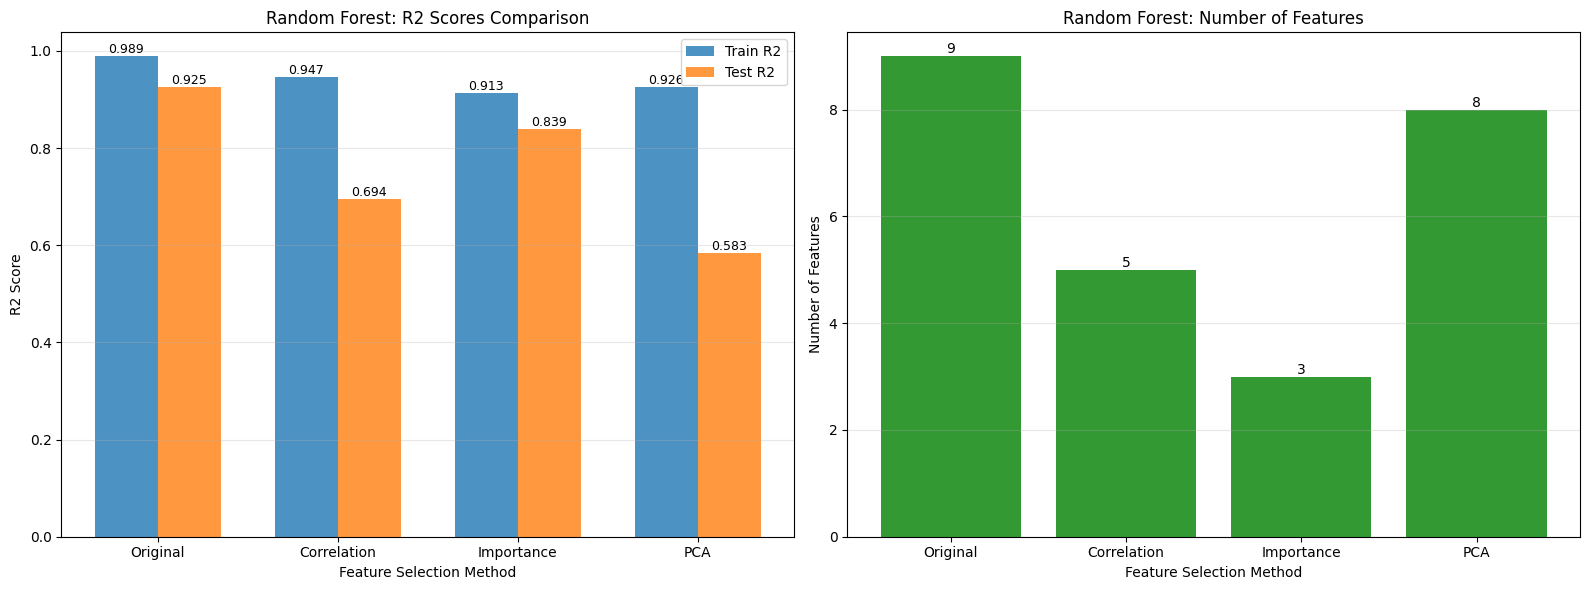

In [62]:
methods = ['Original', 'Correlation', 'Importance', 'PCA']
train_r2_fs = [original_result['train_r2'], results_corr['train_r2'], results_imp['train_r2'], results_pca['train_r2']]
test_r2_fs = [original_result['test_r2'], results_corr['test_r2'], results_imp['test_r2'], results_pca['test_r2']]
n_features_list = [X_train.shape[1], len(selected_features_corr), len(selected_features_importance), pca_variance.n_components_]

x_pos = np.arange(len(methods))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R2 scores
bars1 = ax1.bar(x_pos - width/2, train_r2_fs, width, label='Train R2', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, test_r2_fs, width, label='Test R2', alpha=0.8)
ax1.set_xlabel('Feature Selection Method')
ax1.set_ylabel('R2 Score')
ax1.set_title(f'{model_name}: R2 Scores Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(methods)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Number of features
bars3 = ax2.bar(methods, n_features_list, alpha=0.8, color='green')
ax2.set_xlabel('Feature Selection Method')
ax2.set_ylabel('Number of Features')
ax2.set_title(f'{model_name}: Number of Features')
ax2.set_xticklabels(methods)
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

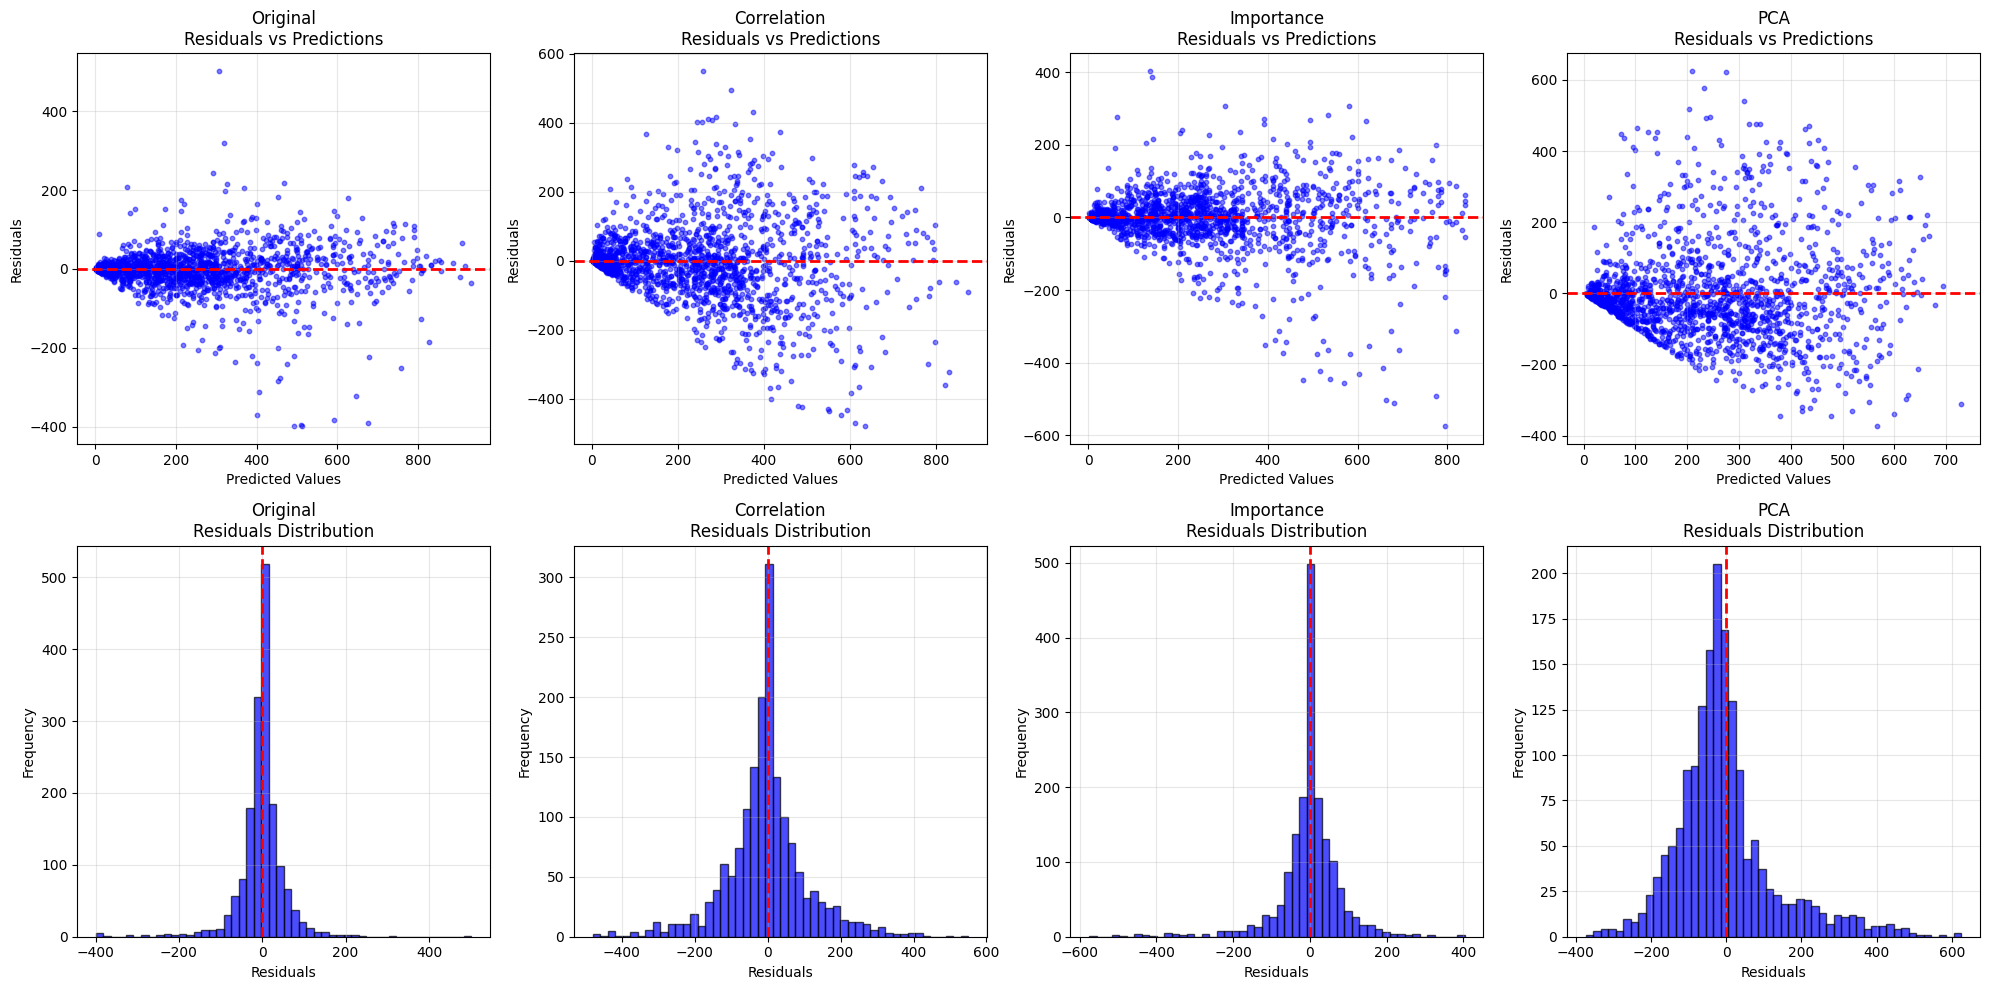

In [62]:
# Residual plots comparison
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

results_dict = {
    'Original': original_result,
    'Correlation': results_corr,
    'Importance': results_imp,
    'PCA': results_pca
}

for idx, (method, res) in enumerate(results_dict.items()):
    # Residuals vs predicted
    axes[0, idx].scatter(res['test_pred'], res['test_residuals'], alpha=0.5, s=10, color='b')
    axes[0, idx].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0, idx].set_xlabel('Predicted Values')
    axes[0, idx].set_ylabel('Residuals')
    axes[0, idx].set_title(f'{method}\nResiduals vs Predictions')
    axes[0, idx].grid(True, alpha=0.3)

    # Residuals histogram
    axes[1, idx].hist(res['test_residuals'], bins=50, edgecolor='black', alpha=0.7, color='b')
    axes[1, idx].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1, idx].set_xlabel('Residuals')
    axes[1, idx].set_ylabel('Frequency')
    axes[1, idx].set_title(f'{method}\nResiduals Distribution')
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Bonus: Neural Network

Deep learning approach using PyTorch. Neural networks can capture complex non-linear patterns through multiple hidden layers.

**Architecture**:
- Input layer: Number of features
- Hidden layers: [128, 64, 32] neurons with ReLU activation
- Output layer: Single neuron for regression
- Optimizer: Adam with learning rate 0.001
- Loss: MSE (Mean Squared Error)

**Training Strategy**:
- Batch size: 256
- Early stopping: Patience of 100 epochs
- Best model selection based on validation R²

In [145]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor((y_train).values).reshape(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor((y_test).values).reshape(-1, 1).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

print(f"Num features: {X_train_tensor.shape[1]}")
print(f"Train samples: {X_train_tensor.shape[0]}")
print(f"Test samples: {X_test_tensor.shape[0]}")

Using device: cuda
Num features: 9
Train samples: 6820
Test samples: 1705


In [146]:
class BikeNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.3):
        super(BikeNN, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

input_size = X_train_tensor.shape[1]
model = BikeNN(input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.3).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

BikeNN(
  (network): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 11649


In [147]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [148]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def evaluate(model, X, y, criterion):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
        loss = criterion(predictions, y)

        y_np = y.cpu().numpy()
        pred_np = predictions.cpu().numpy()
        r2 = r2_score(y_np, pred_np)
        rmse = np.sqrt(mean_squared_error(y_np, pred_np))

    return loss.item(), r2, rmse, pred_np

In [149]:
num_epochs = 500
train_losses = []
test_losses = []
train_r2_scores = []
test_r2_scores = []

early_stop_patience = 100
patience_counter = 0

best_test_r2 = -float('inf')
best_model_state = None

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)

    test_loss, test_r2, test_rmse, _ = evaluate(model, X_test_tensor, y_test_tensor, criterion)
    _, train_r2, train_rmse, _ = evaluate(model, X_train_tensor, y_train_tensor, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    if test_r2 > best_test_r2:
        best_test_r2 = test_r2
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1

    if early_stop_patience and patience_counter >= early_stop_patience:
        print(f"\nEarly stopping at epoch {epoch}")
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {train_loss:.4f}, Train R2: {train_r2:.4f}, Train RMSE: {train_rmse:.2f}')
        print(f'  Test Loss: {test_loss:.4f}, Test R2: {test_r2:.4f}, Test RMSE: {test_rmse:.2f}')

print(f"\nBest Test R2: {best_test_r2:.4f}")

model.load_state_dict(best_model_state)

Epoch [10/500]
  Train Loss: 28951.4572, Train R2: 0.3408, Train RMSE: 169.95
  Test Loss: 29377.3008, Test R2: 0.3194, Test RMSE: 171.40
Epoch [20/500]
  Train Loss: 27525.8228, Train R2: 0.3741, Train RMSE: 165.60
  Test Loss: 27953.5645, Test R2: 0.3523, Test RMSE: 167.19
Epoch [30/500]
  Train Loss: 23184.2377, Train R2: 0.4787, Train RMSE: 151.13
  Test Loss: 23478.5645, Test R2: 0.4560, Test RMSE: 153.23
Epoch [40/500]
  Train Loss: 17536.9296, Train R2: 0.6058, Train RMSE: 131.43
  Test Loss: 18506.9844, Test R2: 0.5712, Test RMSE: 136.04
Epoch [50/500]
  Train Loss: 14355.4543, Train R2: 0.6756, Train RMSE: 119.22
  Test Loss: 15549.9854, Test R2: 0.6397, Test RMSE: 124.70
Epoch [60/500]
  Train Loss: 12652.4279, Train R2: 0.7158, Train RMSE: 111.59
  Test Loss: 13928.9717, Test R2: 0.6773, Test RMSE: 118.02
Epoch [70/500]
  Train Loss: 10768.8703, Train R2: 0.7596, Train RMSE: 102.63
  Test Loss: 11803.4375, Test R2: 0.7265, Test RMSE: 108.64
Epoch [80/500]
  Train Loss: 8421.

<All keys matched successfully>

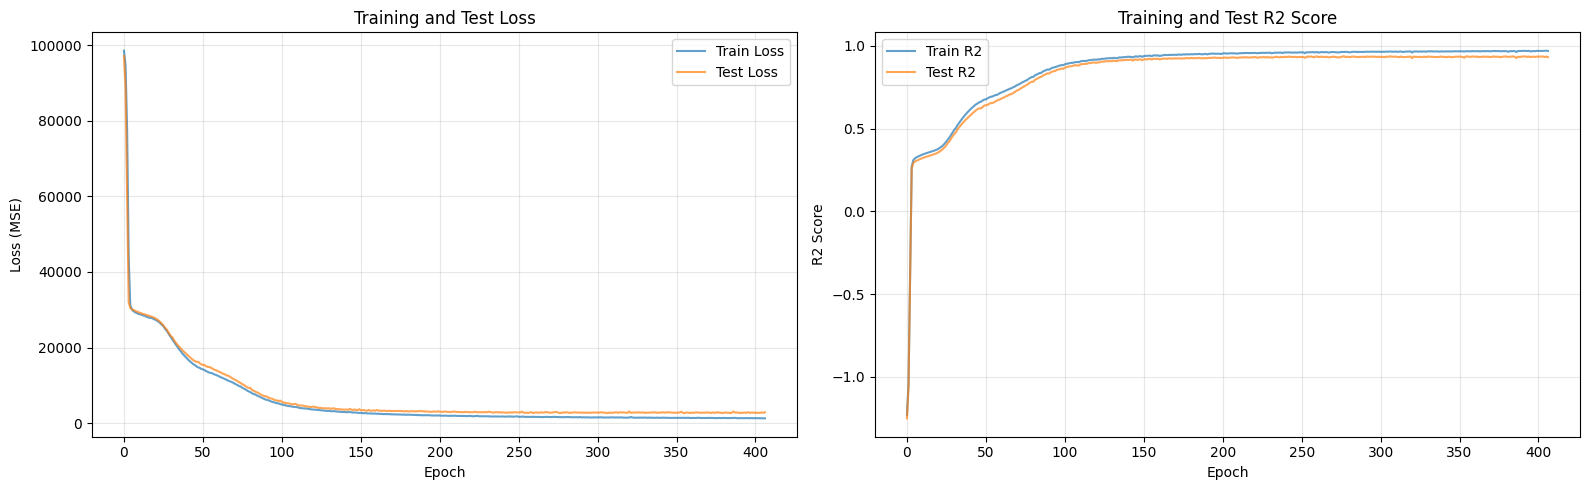

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', alpha=0.7)
axes[0].plot(test_losses, label='Test Loss', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# R2
axes[1].plot(train_r2_scores, label='Train R2', alpha=0.7)
axes[1].plot(test_r2_scores, label='Test R2', alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R2 Score')
axes[1].set_title('Training and Test R2 Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [160]:
train_loss, train_r2, train_rmse, train_pred = evaluate(model, X_train_tensor, y_train_tensor, criterion)
test_loss, test_r2, test_rmse, test_pred = evaluate(model, X_test_tensor, y_test_tensor, criterion)

train_pred = train_pred.flatten()
test_pred = test_pred.flatten()

train_residuals = y_train.values - train_pred
test_residuals = y_test.values - test_pred

results["Neural Network"] = {
    'train_mse': train_loss,
    'train_rmse': train_rmse,
    'train_r2': train_r2,
    'test_mse': test_loss,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'train_pred': train_pred,
    'test_pred': test_pred,
    'train_residuals': train_residuals,
    'test_residuals': test_residuals
}

best_models["Neural Network"] = model

print("Neural Network - Final Results:")
print(f"Train R2: {train_r2:.4f}, Train RMSE: {train_rmse:.2f}")
print(f"Test R2: {test_r2:.4f}, Test RMSE: {test_rmse:.2f}")

Neural Network - Final Results:
Train R2: 0.9701, Train RMSE: 36.18
Test R2: 0.9328, Test RMSE: 53.87


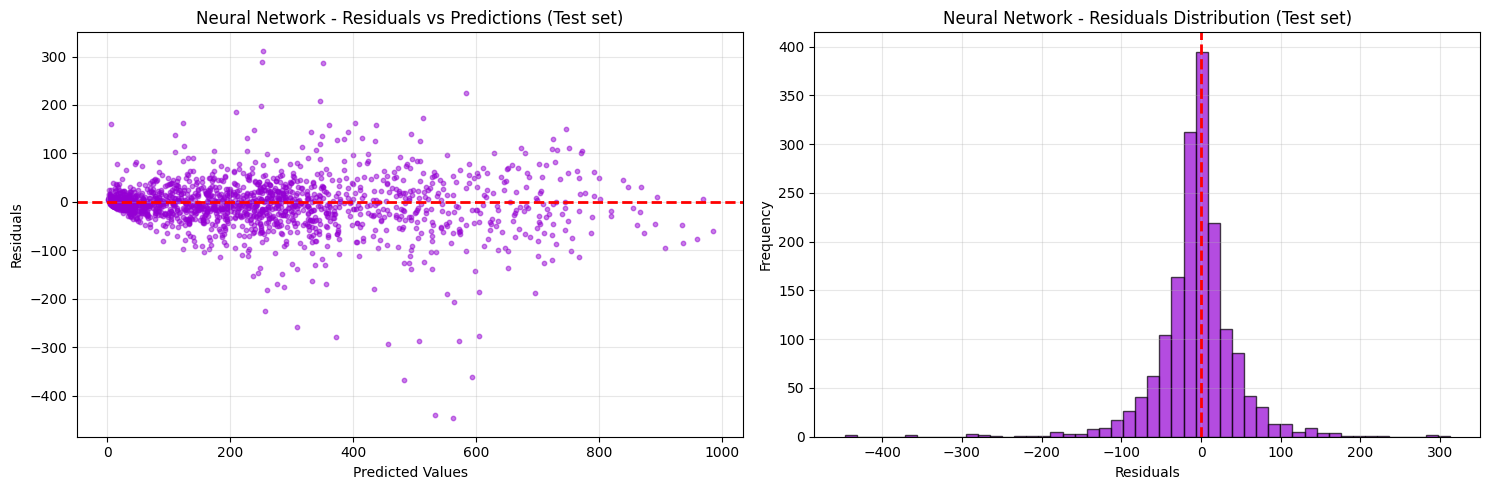

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residuals vs predicted
axes[0].scatter(test_pred, test_residuals, alpha=0.5, s=10, color='darkviolet')
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Neural Network - Residuals vs Predictions (Test set)')
axes[0].grid(True, alpha=0.3)

# Residuals histogram
axes[1].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7, color='darkviolet')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Neural Network - Residuals Distribution (Test set)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Bonus: Clustering Analysis

K-Means clustering to discover natural groupings in the data. This can reveal:
- Different usage patterns (e.g., commuters vs leisure riders)
- Weather-based segments
- Temporal clusters

**Cluster-Specific Models**: Training separate models for each cluster can improve performance if clusters have distinct patterns.

In [153]:
from sklearn.cluster import KMeans

X_clustering = df_without_outliers.drop(columns=['count'])

scaler_cluster = StandardScaler()
X_clustering_scaled = scaler_cluster.fit_transform(X_clustering)

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED, n_init=10)
cluster_labels = kmeans.fit_predict(X_clustering_scaled)

print(f"Number of samples in each cluster:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(cluster_labels)*100:.1f}%)")

df_with_clusters = df_without_outliers.copy()
df_with_clusters['cluster'] = cluster_labels

print()
print("Average values for each cluster")
cluster_stats = df_with_clusters.groupby('cluster').mean().round(2)
print(cluster_stats)

Number of samples in each cluster:
  Cluster 0: 1695 samples (19.9%)
  Cluster 1: 1154 samples (13.5%)
  Cluster 2: 2561 samples (30.0%)
  Cluster 3: 260 samples (3.0%)
  Cluster 4: 1131 samples (13.3%)
  Cluster 5: 1724 samples (20.2%)

Average values for each cluster
         month   hour  holiday  weekday  workingday  weather  temperature  \
cluster                                                                     
0         6.09   4.61      0.0     3.13         1.0     0.09        13.16   
1         6.49  11.25      0.0     0.00         0.0     0.28        15.05   
2         6.39  16.52      0.0     3.13         1.0     0.13        19.16   
3         6.68  11.60      1.0     1.55         0.0     0.27        14.00   
4         6.73  11.45      0.0     6.00         0.0     0.29        15.83   
5         7.05  10.88      0.0     2.88         0.9     1.35        14.07   

         humidity  windspeed   count  
cluster                               
0           68.46       8.70  133.7

C:\Users\balog\AppData\Local\Temp\ipykernel_28756\2311507480.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


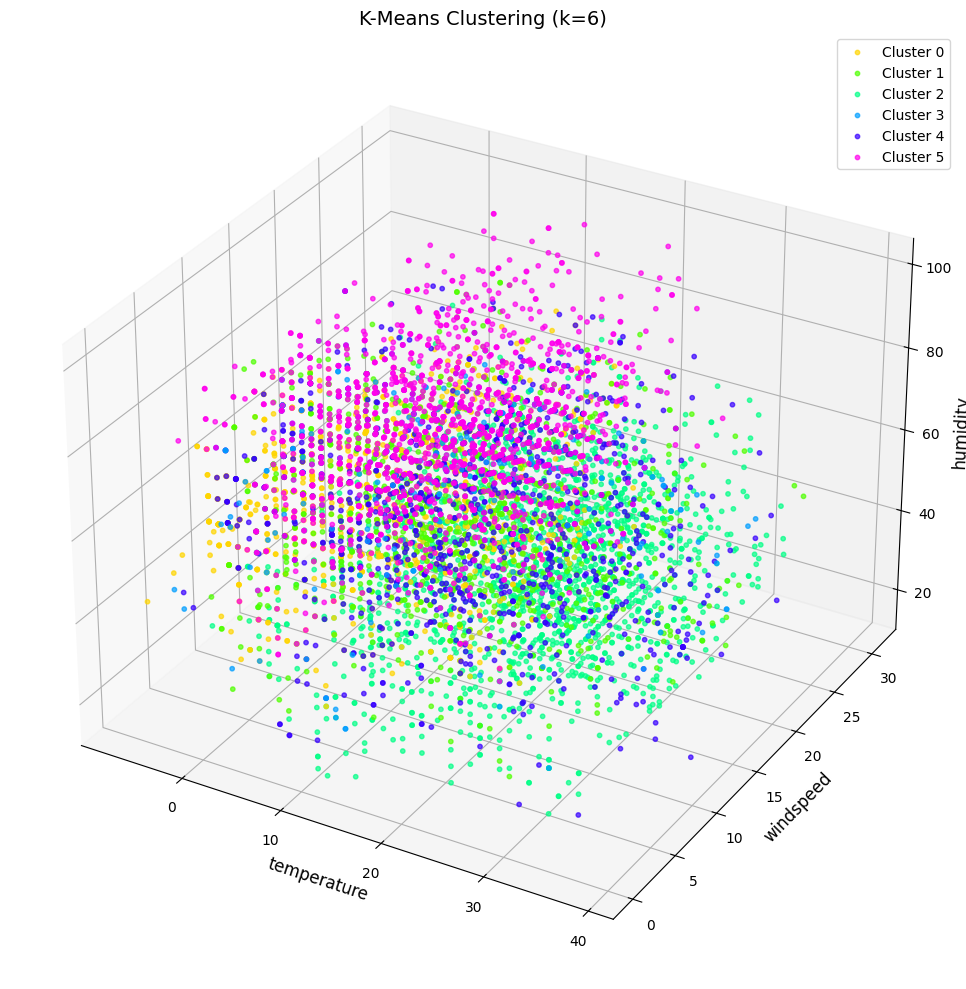

In [154]:
f1 = 'humidity'
f2 = 'windspeed'
f3 = 'temperature'
viz_features = [f3, f2, f1]


X_viz = df_with_clusters[viz_features]

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette("hsv", n_clusters)
cluster_names = [f'Cluster {i}' for i in range(n_clusters)]

for i in range(n_clusters):
    cluster_data = X_viz[cluster_labels == i]
    ax.scatter(
        cluster_data[viz_features[0]],
        cluster_data[viz_features[1]],
        cluster_data[viz_features[2]],
        c=colors[i],
        label=cluster_names[i],
        s=10,
        alpha=0.7
    )

ax.set_xlabel(viz_features[0], fontsize=12)
ax.set_ylabel(viz_features[1], fontsize=12)
ax.set_zlabel(viz_features[2], fontsize=12)
ax.set_title(f'K-Means Clustering (k={n_clusters})', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

In [155]:
cluster_results = {}
best_model_name = "Random Forest"

for cluster_id in range(n_clusters):
    rprint("-" * 50)
    print(f"Training {best_model_name} for Cluster {cluster_id}")

    cluster_mask_train = df_with_clusters.loc[X_train.index, "cluster"] == cluster_id
    cluster_mask_test = df_with_clusters.loc[X_test.index, "cluster"] == cluster_id

    X_train_cluster = X_train[cluster_mask_train]
    y_train_cluster = y_train[cluster_mask_train]
    X_test_cluster = X_test[cluster_mask_test]
    y_test_cluster = y_test[cluster_mask_test]

    print(
        f"Cluster {cluster_id} - Train samples: {len(X_train_cluster)}, Test samples: {len(X_test_cluster)}"
    )

    scaler_cluster = StandardScaler()
    X_train_cluster_scaled = scaler_cluster.fit_transform(X_train_cluster)
    X_test_cluster_scaled = scaler_cluster.transform(X_test_cluster)

    model_cluster = MODEL_DICT[best_model_name]
    model_cluster.fit(X_train_cluster_scaled, y_train_cluster)

    cluster_eval = evaluate_model(
        model_cluster,
        X_train_cluster_scaled,
        X_test_cluster_scaled,
        y_train_cluster,
        y_test_cluster,
    )

    cluster_results[cluster_id] = {
        "model": model_cluster,
        "evaluation": cluster_eval,
        "train_size": len(X_train_cluster),
        "test_size": len(X_test_cluster),
        "scaler": scaler_cluster,
    }

    rprint(
        f"Train R2: {cluster_eval['train_r2']:.4f}, Test R2: {cluster_eval['test_r2']:.4f}\nTrain RMSE: {cluster_eval['train_rmse']:.2f}, Test RMSE: {cluster_eval['test_rmse']:.2f}"
    )

--------------------------------------------------

Training Random Forest for Cluster 0
Cluster 0 - Train samples: 1354, Test samples: 341


Train R2: 0.9924, Test R2: 0.9412
Train RMSE: 16.59, Test RMSE: 44.02

--------------------------------------------------

Training Random Forest for Cluster 1
Cluster 1 - Train samples: 918, Test samples: 236


Train R2: 0.9895, Test R2: 0.9571
Train RMSE: 20.01, Test RMSE: 39.62

--------------------------------------------------

Training Random Forest for Cluster 2
Cluster 2 - Train samples: 2054, Test samples: 507


Train R2: 0.9880, Test R2: 0.9381
Train RMSE: 21.90, Test RMSE: 49.07

--------------------------------------------------

Training Random Forest for Cluster 3
Cluster 3 - Train samples: 206, Test samples: 54


Train R2: 0.9712, Test R2: 0.8337
Train RMSE: 29.50, Test RMSE: 73.93

--------------------------------------------------

Training Random Forest for Cluster 4
Cluster 4 - Train samples: 892, Test samples: 239


Train R2: 0.9904, Test R2: 0.9545
Train RMSE: 20.41, Test RMSE: 45.05

--------------------------------------------------

Training Random Forest for Cluster 5
Cluster 5 - Train samples: 1396, Test samples: 328


Train R2: 0.9783, Test R2: 0.8356
Train RMSE: 27.57, Test RMSE: 75.15

In [156]:
comparison_cluster_table = Table(title="Models Trained on Clusters vs Original Model", show_header=True, header_style="bold magenta")
comparison_cluster_table.add_column("Model", style="cyan", width=25)
comparison_cluster_table.add_column("Train Size", justify="right")
comparison_cluster_table.add_column("Test Size", justify="right")
comparison_cluster_table.add_column("Train R2", justify="right")
comparison_cluster_table.add_column("Test R2", justify="right")
comparison_cluster_table.add_column("Train RMSE", justify="right")
comparison_cluster_table.add_column("Test RMSE", justify="right")

comparison_cluster_table.add_row(
    f"{best_model_name} (Original)",
    str(len(X_train)),
    str(len(X_test)),
    f"{results[best_model_name]['train_r2']:.3f}",
    f"{results[best_model_name]['test_r2']:.3f}",
    f"{results[best_model_name]['train_rmse']:.2f}",
    f"{results[best_model_name]['test_rmse']:.2f}"
)

for cluster_id, cluster_data in cluster_results.items():
    comparison_cluster_table.add_row(
        f"{best_model_name} (Cluster {cluster_id})",
        str(cluster_data['train_size']),
        str(cluster_data['test_size']),
        f"{cluster_data['evaluation']['train_r2']:.3f}",
        f"{cluster_data['evaluation']['test_r2']:.3f}",
        f"{cluster_data['evaluation']['train_rmse']:.2f}",
        f"{cluster_data['evaluation']['test_rmse']:.2f}"
    )

total_test_samples = sum(c['test_size'] for c in cluster_results.values())
weighted_test_r2 = sum(c['evaluation']['test_r2'] * c['test_size'] for c in cluster_results.values()) / total_test_samples
weighted_test_rmse = sum(c['evaluation']['test_rmse'] * c['test_size'] for c in cluster_results.values()) / total_test_samples

comparison_cluster_table.add_row(
    f"{best_model_name} (Weigh Avg)",
    "-",
    str(total_test_samples),
    "-",
    f"[bold yellow]{weighted_test_r2:.3f}[/bold yellow]",
    "-",
    f"[bold yellow]{weighted_test_rmse:.2f}[/bold yellow]"
)

rprint(comparison_cluster_table)

                            Models Trained on Clusters vs Original Model                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model                     ┃ Train Size ┃ Test Size ┃ Train R2 ┃ Test R2 ┃ Train RMSE ┃ Test RMSE ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Random Forest (Original)  │       6820 │      1705 │    0.989 │   0.925 │      22.22 │     57.00 │
│ Random Forest (Cluster 0) │       1354 │       341 │    0.992 │   0.941 │      16.59 │     44.02 │
│ Random Forest (Cluster 1) │        918 │       236 │    0.989 │   0.957 │      20.01 │     39.62 │
│ Random Forest (Cluster 2) │       2054 │       507 │    0.988 │   0.938 │      21.90 │     49.07 │
│ Random Forest (Cluster 3) │        206 │        54 │    0.971 │   0.834 │      29.50 │     73.93 │
│ Random Forest (Cluster 4) │        892 │       239 │    0.990 │   0.955 │      20.41 │     45.05 │
│ Random Forest (Cluster 5) │       1396 │       328 │    0.978 │   0.836 │      27.57 │     75.15 │
│ Random Forest (Weigh Avg) │          - │      1705 │        - │   0.921 │          - │     51.99 │
└───────────────────────────┴────────────┴───────────┴──────────┴─────────┴────────────┴───────────┘

In [157]:
cluster_analysis_table = Table(
    title="Cluster Characteristics Analysis", show_header=True, header_style="bold cyan"
)
cluster_analysis_table.add_column("Cluster", style="yellow", width=10)
cluster_analysis_table.add_column("Samples", justify="right")
cluster_analysis_table.add_column("Percentage", justify="right")
cluster_analysis_table.add_column("Avg Count", justify="right")
cluster_analysis_table.add_column("Std Count", justify="right")
cluster_analysis_table.add_column("Avg Hour", justify="right")
cluster_analysis_table.add_column("Avg Temp", justify="right")
cluster_analysis_table.add_column("Avg Hum", justify="right")
cluster_analysis_table.add_column("Weather", justify="left")
cluster_analysis_table.add_column("Test R2", justify="right")

weather_mapping = {0: "clear", 1: "cloudy", 2: "light rain/snow", 3: "heavy rain/snow"}

for cluster_id in range(n_clusters):
    cluster_data = df_with_clusters[df_with_clusters["cluster"] == cluster_id]

    samples = len(cluster_data)
    percentage = samples / len(df_with_clusters) * 100
    avg_count = cluster_data["count"].mean()
    std_count = cluster_data["count"].std()
    avg_hour = cluster_data["hour"].mean()
    avg_temp = cluster_data["temperature"].mean()
    avg_humid = cluster_data["humidity"].mean()
    most_common_weather = cluster_data["weather"].mode().values[0]
    most_common_weather = weather_mapping.get(most_common_weather, "-")

    test_r2 = f"{cluster_results[cluster_id]['evaluation']['test_r2']:.3f}"

    cluster_analysis_table.add_row(
        str(cluster_id),
        str(samples),
        f"{percentage:.1f}%",
        f"{avg_count:.1f}",
        f"{std_count:.1f}",
        f"{avg_hour:.1f}",
        f"{avg_temp:.1f}°C",
        f"{avg_humid:.1f}%",
        str(most_common_weather),
        test_r2,
    )

rprint(cluster_analysis_table)

                                        Cluster Characteristics Analysis                                         
┏━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Cluster    ┃ Samples ┃ Percentage ┃ Avg Count ┃ Std Count ┃ Avg Hour ┃ Avg Temp ┃ Avg Hum ┃ Weather ┃ Test R2 ┃
┡━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ 0          │    1695 │      19.9% │     133.8 │     189.0 │      4.6 │   13.2°C │   68.5% │ clear   │   0.941 │
│ 1          │    1154 │      13.5% │     215.8 │     194.6 │     11.2 │   15.1°C │   59.5% │ clear   │   0.957 │
│ 2          │    2561 │      30.0% │     337.7 │     199.2 │     16.5 │   19.2°C │   47.7% │ clear   │   0.938 │
│ 3          │     260 │       3.0% │     185.5 │     176.4 │     11.6 │   14.0°C │   61.5% │ clear   │   0.834 │
│ 4          │    1131 │      13.3% │     248.6 │     209.0 │     11.5 │   15.8°C │   59.6% │ clear   │   0.955 │
│ 5          │    1724 │      20.2% │     190.9 │     186.9 │     10.9 │   14.1°C │   77.6% │ cloudy  │   0.836 │
└────────────┴─────────┴────────────┴───────────┴───────────┴──────────┴──────────┴─────────┴─────────┴─────────┘